#Garbage Classification with Machine Learning
## Data Science Project Workflow

### Project Overview
- **Objective**: This project addresses the growing need for efficient waste management and recycling 
by enabling accurate garbage classification, which can be integrated into smart waste management 
systems.
- **Milestones**: Data Collection, Exploration, Preprocessing, Advanced Analysis, Model Development, Deployment, and Final Documentation.

---

# Team Information

### Team Members
- **Name**: [Mohamed Mahdy Mohamed]  
  **Email**: [nagy1018078@gmail.com]  
  
- **Name**: [Menna Khaled Saad]  
  **Email**: [mennakhlaled231@gmail.com]  

- **Name**: [Rawan Mohamed Taha]  
  **Email**: [rm086334556@gmail.com]  
  
- **Name**: [Hagar Essam]  
  **Email**: [essamhager974@gmail.com]  

- **Name**: [Mohamed Abdelwahed Mohamed]  
  **Email**: [ma6639@fayoum.edu.eg]  


# Milestone 1: Data Collection, Exploration, and Preprocessing

### Setup and Data Download

In [42]:
# Core libraries
import os
import shutil
import random
import zipfile
import hashlib
import json
from copy import deepcopy
from datetime import datetime

# Image handling
from PIL import Image

# Web scraping for image data
from icrawler.builtin import BingImageCrawler

# Data processing and manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go

# Dash for web applications
import dash
from dash import dcc, html, Input, Output, State
import dash_bootstrap_components as dbc
from dash import dash_table
import base64
import io

# Progress bar
from tqdm import tqdm

# Machine Learning Libraries
import mlflow
import joblib
import optuna
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    precision_recall_fscore_support,
    log_loss,
    balanced_accuracy_score,
    roc_auc_score
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, StackingClassifier, VotingClassifier

# PyTorch and torchvision
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms, models

# Statistical tests
from scipy.stats import ks_2samp, wasserstein_distance

In [2]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {torch.cuda.get_device_name(0) if device.type == 'cuda' else 'CPU'}")

Using device: NVIDIA GeForce RTX 3060 Laptop GPU


In [4]:
# Kaggle credentials
os.environ['KAGGLE_USERNAME'] = "mohamedabdelmonem123"
os.environ['KAGGLE_KEY'] = "5d6639c1adcad3f1291426c6e77ab109"

# Download the first dataset
!kaggle datasets download -d farzadnekouei/trash-type-image-dataset

# Download the second dataset
!kaggle datasets download -d asdasdasasdas/garbage-classification


Dataset URL: https://www.kaggle.com/datasets/farzadnekouei/trash-type-image-dataset
License(s): unknown




  0%|          | 0.00/40.9M [00:00<?, ?B/s]
100%|██████████| 40.9M/40.9M [00:00<00:00, 1.08GB/s]


Dataset URL: https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification
License(s): copyright-authors




  0%|          | 0.00/82.0M [00:00<?, ?B/s]
100%|██████████| 82.0M/82.0M [00:00<00:00, 1.11GB/s]


### Data Collection


In [5]:
# Unzip multiple zip files
zip_files = ['garbage-classification.zip', 'trash-type-image-dataset.zip']

for zip_file in zip_files:
    with zipfile.ZipFile(zip_file, 'r') as zip_ref:
        zip_ref.extractall('./')
    print(f"Extracted: {zip_file}")

Extracted: garbage-classification.zip
Extracted: trash-type-image-dataset.zip


In [6]:
# Define source and target directories
dataset_dirs = [
    "Garbage classification/Garbage classification",
    "TrashType_Image_Dataset"
]
output_dir = "./Combined"
os.makedirs(output_dir, exist_ok=True)

# Track unique images using hashes
seen_hashes = set()
total = 0

# Combine datasets with deduplication
for dataset_dir in dataset_dirs:
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        output_class_path = os.path.join(output_dir, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                with Image.open(img_path) as img:
                    img = img.resize((128, 128)).convert("RGB")
                    img_hash = hashlib.md5(img.tobytes()).hexdigest()

                    if img_hash not in seen_hashes:
                        seen_hashes.add(img_hash)
                        save_path = os.path.join(output_class_path, f"{img_hash}.jpg")
                        img.save(save_path)
                        total += 1
            except Exception as e:
                print(f"Error: {img_path}: {e}")

print(f"Total unique images in combined dataset: {total}")

Total unique images in combined dataset: 2524


### Intial Data Exploration and Cleaning 

       Class  Image Count
0  cardboard          403
1      glass          501
2      metal          409
3      paper          594
4    plastic          480
5      trash          137


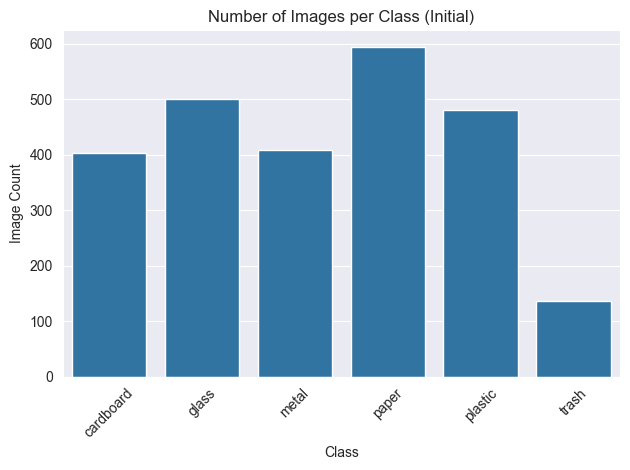

In [7]:
# Analyze initial class distribution
data_path = "./Combined"
class_counts = {}

# Count the number of images in each class folder
for class_name in os.listdir(data_path):
    class_folder = os.path.join(data_path, class_name)
    if not class_name.startswith('.') and os.path.isdir(class_folder):
        class_counts[class_name] = len(os.listdir(class_folder))

# Create DataFrame for better visualization
df = pd.DataFrame(list(class_counts.items()), columns=["Class", "Image Count"])

# Display the class distribution
print(df)

# Plot the distribution using a bar plot
sns.barplot(x="Class", y="Image Count", data=df)
plt.xticks(rotation=45)
plt.title("Number of Images per Class (Initial)")
plt.tight_layout()  # To avoid label cut-off
plt.show()

In [8]:
# Load MobileNetV2 model from torchvision
mobilenet_model = torchvision.models.mobilenet_v2(pretrained=True)
mobilenet_model.classifier = nn.Sequential(
    nn.Dropout(0.2),
    nn.Linear(mobilenet_model.last_channel, 1000),  # Adjust output if needed for direct embedding
    nn.AdaptiveAvgPool2d(1)  # Add pooling for consistent embedding size
)
mobilenet_model.eval()  # Set to evaluation mode

# Function to scrape images from Bing
def scrape_images(keyword, output_dir, num_images):
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)
    crawler = BingImageCrawler(storage={'root_dir': output_dir})
    crawler.crawl(keyword=keyword, max_num=num_images)

# Function to extract image embeddings using MobileNetV2
def extract_embedding(img_path):
    try:
        # Load and preprocess the image
        img = Image.open(img_path).convert('RGB')
        preprocess = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
        img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension

        # Extract features using MobileNetV2
        with torch.no_grad():
            features = mobilenet_model.features(img_tensor)
            embedding = torch.mean(features, dim=[2, 3])  # Global average pooling

        return embedding.squeeze().numpy()

    except Exception as e:
        print(f"Error extracting embedding for {img_path}: {e}")
        return None

C:\Users\nagy1\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\nagy1\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
# Scrape missing images for underrepresented classes
to_scrape = {
    'metal': 90,
    'plastic': 20,
    'cardboard': 97,
}

keywords = {
    'metal': 'metal waste trash',
    'plastic': 'plastic waste trash',
    'cardboard': 'cardboard waste recycling',
}

scraping_output_dir = "./scraping"
os.makedirs(scraping_output_dir, exist_ok=True)

for class_name, num_images in to_scrape.items():
    print(f"Scraping {num_images} images for class: {class_name}")
    class_output_dir = os.path.join(scraping_output_dir, class_name)
    scrape_images(keyword=keywords[class_name], output_dir=class_output_dir, num_images=num_images)

2025-05-12 03:32:40,885 - INFO - icrawler.crawler - start crawling...
2025-05-12 03:32:40,886 - INFO - icrawler.crawler - starting 1 feeder threads...
2025-05-12 03:32:40,890 - INFO - feeder - thread feeder-001 exit
2025-05-12 03:32:40,897 - INFO - icrawler.crawler - starting 1 parser threads...
2025-05-12 03:32:40,902 - INFO - icrawler.crawler - starting 1 downloader threads...


Scraping 90 images for class: metal


2025-05-12 03:32:42,557 - INFO - parser - parsing result page https://www.bing.com/images/async?q=metal waste trash&first=0
2025-05-12 03:32:43,788 - INFO - downloader - image #1	https://as1.ftcdn.net/v2/jpg/02/99/08/70/1000_F_299087002_UbVd27o2oB6NZgaOGdnjdJVtAX8JvbeF.jpg
2025-05-12 03:32:50,396 - INFO - downloader - image #2	https://www.jdogjunkremoval.com/wp-content/uploads/2019/04/scrapmetal-768x768.jpg
2025-05-12 03:32:56,198 - INFO - downloader - image #3	https://get.pxhere.com/photo/rust-pile-metal-junk-material-rubbish-rubble-waste-junkyard-trash-dump-iron-garbage-earthquake-pollution-recycling-landfill-heap-scrap-scrapyard-scrap-yard-1141570.jpg
2025-05-12 03:32:57,990 - INFO - downloader - image #4	https://thumbs.dreamstime.com/b/metal-waste-6638945.jpg
2025-05-12 03:33:01,208 - INFO - downloader - image #5	https://thumbs.dreamstime.com/z/metal-trash-garbage-used-as-manufacturing-casting-ceper-klaten-central-java-thursday-31531442.jpg
2025-05-12 03:33:01,729 - INFO - download

Scraping 20 images for class: plastic


2025-05-12 03:34:02,565 - INFO - parser - parsing result page https://www.bing.com/images/async?q=plastic waste trash&first=0
2025-05-12 03:34:03,551 - INFO - downloader - image #1	https://thumbs.dreamstime.com/z/waste-plastic-garbage-trash-many-lots-pollution-pile-220399716.jpg
2025-05-12 03:34:16,877 - INFO - downloader - image #2	https://get.pxhere.com/photo/plastic-environment-litter-waste-dump-garbage-pollution-garbage-bag-423456.jpg
2025-05-12 03:34:26,387 - INFO - downloader - image #3	https://get.pxhere.com/photo/plastic-bottles-waste-cube-garbage-recycling-circuit-pressed-environmental-protection-trashbin-plastic-bottles-presses-garbage-collection-pressed-together-1125480.jpg
2025-05-12 03:34:28,464 - INFO - downloader - image #4	https://scitechdaily.com/images/Plastic-Waste-Recycled.jpg
2025-05-12 03:34:31,368 - INFO - downloader - image #5	https://pixahive.com/wp-content/uploads/2021/03/Plastic-wastes-on-ocean-floor-385274-pixahive.jpg
2025-05-12 03:34:33,137 - INFO - downlo

Scraping 97 images for class: cardboard


2025-05-12 03:34:52,596 - INFO - parser - parsing result page https://www.bing.com/images/async?q=cardboard waste recycling&first=0
2025-05-12 03:34:53,454 - INFO - downloader - image #1	https://www.conserve-energy-future.com/wp-content/uploads/2016/01/cardboard-recycling-1.jpg
2025-05-12 03:34:53,721 - ERROR - downloader - Response status code 403, file https://recyclingworksma.com/wp-content/uploads/2012/01/cardboard.jpg
2025-05-12 03:34:53,918 - ERROR - downloader - Response status code 403, file https://www.businesswaste.co.uk/wp-content/uploads/2022/09/cardboard-boxes-scaled.jpg
2025-05-12 03:34:57,520 - INFO - downloader - image #2	https://www.instantwaste.com.au/wp-content/uploads/2022/09/IMG_0966-2048x1536.jpg
2025-05-12 03:34:59,274 - INFO - downloader - image #3	https://bewi.com/wp-content/uploads/2021/06/Cardboard_recycling_IMG_8286-org-scaled.jpg
2025-05-12 03:34:59,965 - INFO - downloader - image #4	https://cartwrightswastedisposal.co.uk/wp-content/uploads/2016/09/cardboar

In [10]:
# Combine original and scraped datasets, removing duplicates via image hash
dataset_dirs = [
    "./Combined",
    "./scraping"
]
output_dir = "./combine&scraping"
os.makedirs(output_dir, exist_ok=True)

seen_hashes = set()
unique_count = 0

for dataset_dir in dataset_dirs:
    for class_name in os.listdir(dataset_dir):
        class_path = os.path.join(dataset_dir, class_name)
        if not os.path.isdir(class_path):
            continue

        output_class_path = os.path.join(output_dir, class_name)
        os.makedirs(output_class_path, exist_ok=True)

        for img_file in os.listdir(class_path):
            img_path = os.path.join(class_path, img_file)
            try:
                with Image.open(img_path) as img:
                    img = img.resize((128, 128)).convert("RGB")
                    img_hash = hashlib.md5(img.tobytes()).hexdigest()

                    if img_hash in seen_hashes:
                        continue

                    seen_hashes.add(img_hash)
                    save_path = os.path.join(output_class_path, f"{img_hash}.jpg")
                    img.save(save_path)
                    unique_count += 1

            except Exception as e:
                print(f"Error processing {img_path}: {e}")

print(f"Total unique images after including scraped data: {unique_count}")

Total unique images after including scraped data: 2634


       Class  Image Count
0  cardboard          457
1      glass          501
2      metal          452
3      paper          594
4    plastic          493
5      trash          137


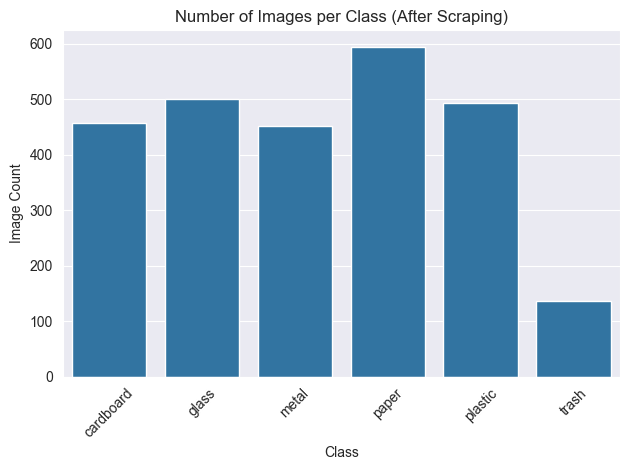

In [11]:
# Analyze class distribution after combining scraped images
data_path = "./combine&scraping"
class_counts = {}

for class_name in os.listdir(data_path):
    class_folder = os.path.join(data_path, class_name)
    if os.path.isdir(class_folder):
        class_counts[class_name] = len(os.listdir(class_folder))

df = pd.DataFrame(class_counts.items(), columns=["Class", "Image Count"])
print(df)

# Plot the updated class distribution
sns.barplot(x="Class", y="Image Count", data=df)
plt.xticks(rotation=45)
plt.title("Number of Images per Class (After Scraping)")
plt.tight_layout()
plt.show()


In [12]:
# Remove Corrupted Images
dataset_path = "./combine&scraping"

def remove_corrupted_images():
    print("Removing corrupted images...")
    for class_dir in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_dir)
        if not os.path.isdir(class_path):
            continue
        for img_file in tqdm(os.listdir(class_path), desc=f"Checking {class_dir}"):
            img_path = os.path.join(class_path, img_file)
            try:
                with Image.open(img_path) as img:
                    img.verify()
            except (IOError, OSError):
                print(f"Removing corrupted: {img_path}")
                os.remove(img_path)

remove_corrupted_images()

Removing corrupted images...


Checking trash: 100%|██████████| 137/137 [00:00<00:00, 1655.87it/s]


### Loading Data with Pytorch

In [3]:
# Load Dataset with PyTorch's ImageFolder and DataLoader
dataset_path = "./combine&scraping"
img_size = 128
batch_size = 32

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Load dataset using ImageFolder
dataset = datasets.ImageFolder(root=dataset_path, transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Extract class names and number of classes
class_names = dataset.classes
num_classes = len(class_names)

# Display dataset information
print(f"Number of classes: {num_classes}")
print(f"Class names: {class_names}")
print(f"Total number of samples: {len(dataset)}")
print(f"Number of batches per epoch: {len(dataloader)}")


Number of classes: 6
Class names: ['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']
Total number of samples: 2576
Number of batches per epoch: 81



---

# Milestone 2: Advanced Data Analysis and Feature Engineering

### Mislabeled Image Detection

In [18]:
class QuickCNN(nn.Module):
    def __init__(self, num_classes, img_size=128):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * (img_size // 4) * (img_size // 4), 64),
            nn.ReLU(),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


def train_quick_model(dataloader, num_classes, epochs=3):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = QuickCNN(num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters())

    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct_predictions = 0
        total_samples = 0

        for inputs, labels in tqdm(dataloader, desc=f'Epoch {epoch+1}/{epochs}'):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total_samples += labels.size(0)
            correct_predictions += (predicted == labels).sum().item()

        epoch_loss = running_loss / total_samples
        epoch_accuracy = correct_predictions / total_samples
        print(f'Epoch {epoch+1} Loss: {epoch_loss:.4f} Accuracy: {epoch_accuracy:.4f}')

    model.eval()
    return model, dataloader.dataset.classes


quick_model, class_names = train_quick_model(dataloader, num_classes)

Epoch 1/3: 100%|██████████| 83/83 [00:09<00:00,  8.60it/s]


Epoch 1 Loss: 1.4432 Accuracy: 0.4389


Epoch 2/3: 100%|██████████| 83/83 [00:10<00:00,  7.91it/s]


Epoch 2 Loss: 1.0333 Accuracy: 0.6234


Epoch 3/3: 100%|██████████| 83/83 [00:09<00:00,  8.50it/s]

Epoch 3 Loss: 0.7655 Accuracy: 0.7248


In [20]:
# Filter potentially mislabeled images
def filter_mislabeled(model, class_names, dataset_path, img_size=(128, 128), min_conf_threshold=0.7):
    """Filter potentially mislabeled images based on model predictions.
    
    Args:
        model: Trained PyTorch model
        class_names: List of class names
        dataset_path: Path to dataset directory
        img_size: Target image size (default: (128, 128))
        min_conf_threshold: Minimum confidence threshold for considering mislabeling (default: 0.7)
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device).eval()

    transform_single = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    mislabeled_count = 0

    for class_dir in os.listdir(dataset_path):
        class_path = os.path.join(dataset_path, class_dir)

        if not os.path.isdir(class_path) or class_dir.startswith('.'):
            continue

        for img_file in tqdm(os.listdir(class_path),
                             desc=f"Processing {class_dir}"):
            img_path = os.path.join(class_path, img_file)

            try:
                img = Image.open(img_path).convert('RGB')
                img_tensor = transform_single(img).unsqueeze(0).to(device)

                with torch.no_grad():
                    output = model(img_tensor)
                    probabilities = torch.softmax(output, dim=1)
                    max_prob, predicted_idx = torch.max(probabilities, 1)
                    predicted_class = class_names[predicted_idx.item()]
                    confidence = max_prob.item()

                if (predicted_class != class_dir and
                        confidence > min_conf_threshold):
                    print(f"Mismatch: {img_file} - Predicted: {predicted_class}, "
                          f"Actual: {class_dir}, Confidence: {confidence:.2f}")
                    os.remove(img_path)
                    mislabeled_count += 1

            except Exception as e:
                print(f"Error processing {img_path}: {e}")

    print(f"Found and removed {mislabeled_count} potentially mislabeled images.")


filter_mislabeled(quick_model, class_names, dataset_path)

Processing trash: 100%|██████████| 134/134 [00:00<00:00, 150.47it/s]

Found and removed 0 potentially mislabeled images.


### Data Splitting and Augmentation

    Class  Image Count
cardboard          451
    glass          480
    metal          444
    paper          591
  plastic          476
    trash          134


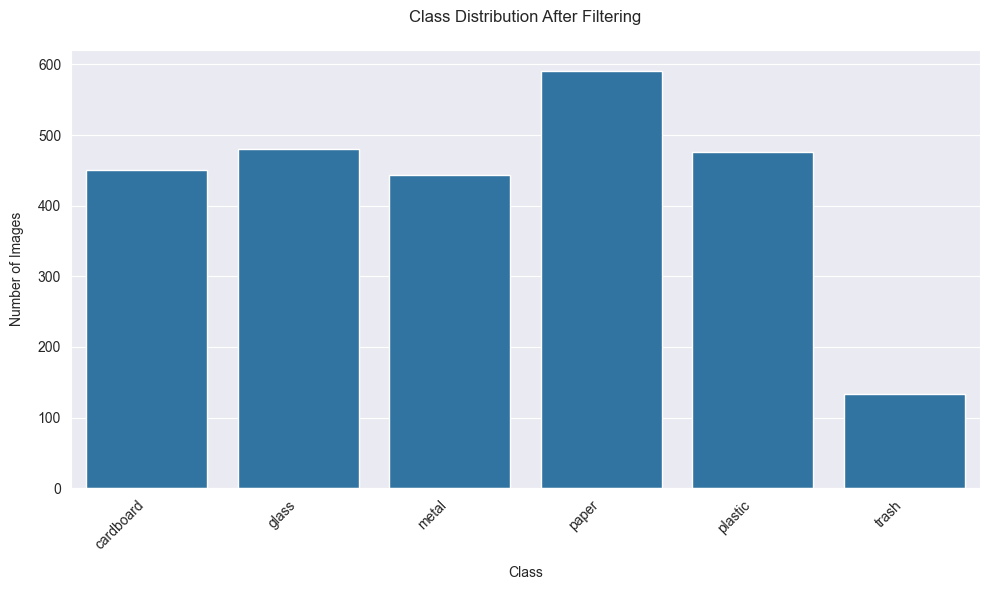

In [21]:
# Analyze class distribution after filtering
def analyze_class_distribution(data_path="./combine&scraping"):
    """Analyze and visualize class distribution in the dataset.
    
    Args:
        data_path: Path to the dataset directory (default: "./combine&scraping")
    """
    # Count images per class
    class_counts = {}
    for class_name in os.listdir(data_path):
        class_dir = os.path.join(data_path, class_name)
        if os.path.isdir(class_dir):
            try:
                class_counts[class_name] = len([
                    f for f in os.listdir(class_dir)
                    if os.path.isfile(os.path.join(class_dir, f))
                ])
            except OSError as e:
                print(f"Error accessing {class_dir}: {e}")
                continue

    # Create and display dataframe
    df = pd.DataFrame.from_dict(class_counts,
                                orient='index',
                                columns=['Image Count'])
    df.index.name = 'Class'
    df.reset_index(inplace=True)
    print(df.to_string(index=False))

    # Visualize distribution
    plt.figure(figsize=(10, 6))
    ax = sns.barplot(x="Class", y="Image Count", data=df)
    ax.set_title("Class Distribution After Filtering", pad=20)
    ax.set_xlabel("Class", labelpad=10)
    ax.set_ylabel("Number of Images", labelpad=10)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()


analyze_class_distribution()

In [22]:
# Split Data into Train, Validation, and Test sets
BASE_DIR = './dataset_split'
DATA_PATH = "./combine&scraping"
TRAIN_SPLIT, VAL_SPLIT = 0.7, 0.15

# Create base directories
train_dir, val_dir, test_dir = [os.path.join(BASE_DIR, x) for x in ['train', 'val', 'test']]
for d in [train_dir, val_dir, test_dir]:
    os.makedirs(d, exist_ok=True)

# Get class names (excluding hidden directories)
class_names = [d for d in os.listdir(DATA_PATH) if not d.startswith('.')]

# Split data for each class
for class_name in class_names:
    class_path = os.path.join(DATA_PATH, class_name)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    random.shuffle(images)

    n_total = len(images)
    n_train = int(TRAIN_SPLIT * n_total)
    n_val = int(VAL_SPLIT * n_total)

    # Define splits
    splits = {
        train_dir: images[:n_train],
        val_dir: images[n_train:n_train + n_val],
        test_dir: images[n_train + n_val:]
    }

    # Copy files to respective directories
    for split_dir, split_images in splits.items():
        class_split_path = os.path.join(split_dir, class_name)
        os.makedirs(class_split_path, exist_ok=True)

        for img in tqdm(split_images,
                        desc=f'Splitting {class_name} -> {os.path.basename(split_dir)}',
                        leave=False):
            src = os.path.join(class_path, img)
            dst = os.path.join(class_split_path, img)
            shutil.copy2(src, dst)  # copy2 preserves metadata

print("\nData splitting completed successfully.")


Data splitting completed successfully.


In [4]:
# Data Normalization and Augmentation for PyTorch
DATA_DIR = './dataset_split'
IMG_SIZE = 128
BATCH_SIZE = 32
NORMALIZATION_MEAN = [0.485, 0.456, 0.406]
NORMALIZATION_STD = [0.229, 0.224, 0.225]

# Define paths
train_dir = os.path.join(DATA_DIR, 'train')
val_dir = os.path.join(DATA_DIR, 'val')
test_dir = os.path.join(DATA_DIR, 'test')

# Common transforms
base_transforms = [
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD)
]

# Training transforms with augmentations
train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.2, 0.2),
        scale=(0.8, 1.2)
    ),
    *base_transforms
])

# Validation and test transforms
val_transforms = transforms.Compose(base_transforms)
test_transforms = transforms.Compose(base_transforms)

# Create datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
val_dataset = datasets.ImageFolder(val_dir, transform=val_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    pin_memory=True
)

# Print dataset statistics
print("Train dataset size:", len(train_dataset))
print("Validation dataset size:", len(val_dataset))
print("Test dataset size:", len(test_dataset))
print("Number of training batches:", len(train_loader))
print("Number of validation batches:", len(val_loader))
print("Number of test batches:", len(test_loader))

Train dataset size: 1800
Validation dataset size: 384
Test dataset size: 392
Number of training batches: 57
Number of validation batches: 12
Number of test batches: 13


### Feature Extraction and Visualization

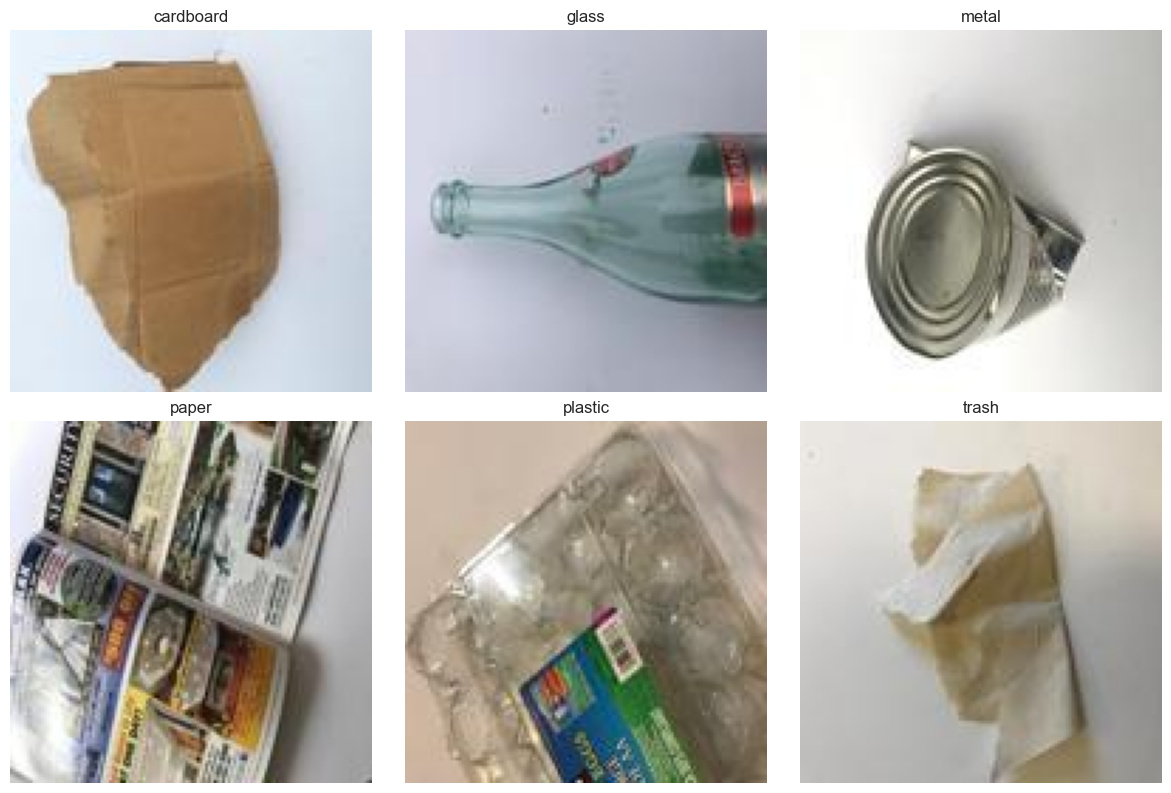

In [24]:
# Sample images from each class
data_path = "./combine&scraping"
class_names = [d for d in os.listdir(data_path) if not d.startswith('.')]

plt.figure(figsize=(12, 8))
for idx, class_name in enumerate(class_names):
    class_dir = os.path.join(data_path, class_name)

    if not os.path.isdir(class_dir):
        continue

    images = [
        f for f in os.listdir(class_dir)
        if f.lower().endswith(('.jpg', '.png', '.jpeg'))
    ]

    if not images:
        continue

    img_name = random.choice(images)
    img_path = os.path.join(class_dir, img_name)

    try:
        img = Image.open(img_path).convert('RGB')
        plt.subplot(2, 3, idx + 1)
        plt.imshow(np.array(img))
        plt.title(class_name)
        plt.axis('off')
    except Exception as e:
        print(f"Error loading image: {img_path} - {e}")

plt.tight_layout()
plt.show()

Processing train folder...
Processing class: cardboard with 120 images.
Processing class: glass with 120 images.
Processing class: metal with 120 images.
Processing class: paper with 120 images.
Processing class: plastic with 120 images.
Processing class: trash with 93 images.
Processing test folder...
Processing class: cardboard with 69 images.
Processing class: glass with 72 images.
Processing class: metal with 68 images.
Processing class: paper with 90 images.
Processing class: plastic with 72 images.
Processing class: trash with 21 images.
Processing val folder...
Processing class: cardboard with 67 images.
Processing class: glass with 72 images.
Processing class: metal with 66 images.
Processing class: paper with 88 images.
Processing class: plastic with 71 images.
Processing class: trash with 20 images.
Total embeddings collected: 1469


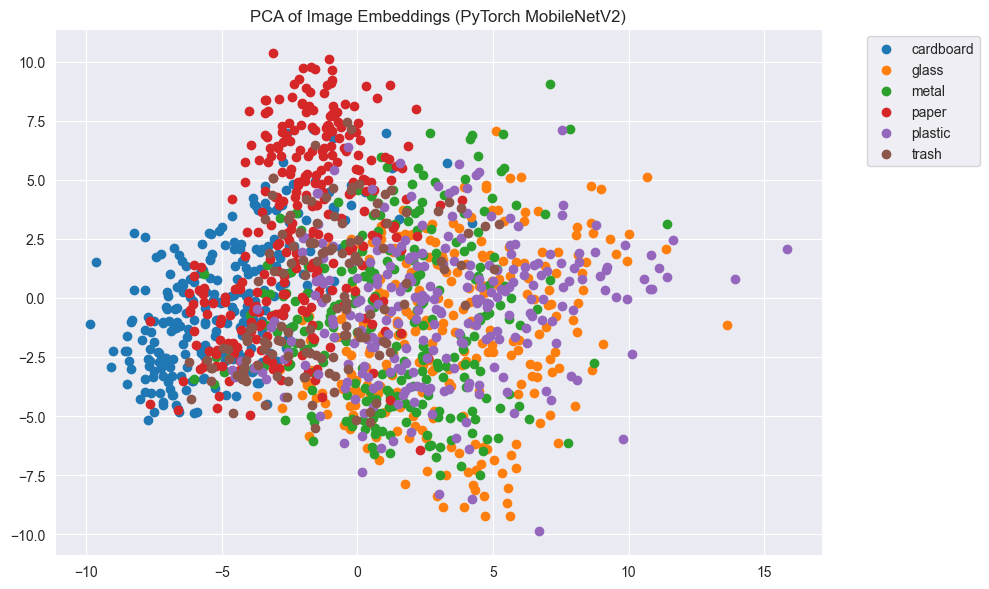

In [25]:
# Embedding Extraction and PCA Visualization (PyTorch)
def extract_pytorch_embedding(img_path, model, transform, device='cuda' if torch.cuda.is_available() else 'cpu'):
    """Extract embedding from an image using PyTorch model.
    
    Args:
        img_path: Path to image file
        model: Pretrained PyTorch model
        transform: Image transformations
        device: Device to run model on
        
    Returns:
        Numpy array of embedding or None if error occurs
    """
    try:
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            features = model.features(img_tensor)
            embedding = torch.mean(features, dim=[2, 3])
        return embedding.squeeze().cpu().numpy()
    except Exception as e:
        print(f"Error extracting embedding from {img_path}: {e}")
        return None

# Configuration
DATA_PATH = './dataset_split'
MAX_IMAGES_PER_CLASS = 120
IMAGE_EXTS = ('.jpg', '.png', '.jpeg')

# Initialize model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mobilenet_model = mobilenet_model.to(device)
mobilenet_model.eval()

# Define transforms
pca_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Collect embeddings
embeddings = []
labels = []

for split_name in ['train', 'test', 'val']:
    split_folder = os.path.join(DATA_PATH, split_name)
    print(f"Processing {split_name} folder...")

    for class_name in os.listdir(split_folder):
        class_folder = os.path.join(split_folder, class_name)
        if not os.path.isdir(class_folder):
            continue

        img_files = [
                        f for f in os.listdir(class_folder)
                        if f.lower().endswith(IMAGE_EXTS)
                    ][:MAX_IMAGES_PER_CLASS]

        print(f"Processing class: {class_name} with {len(img_files)} images.")

        for img_name in img_files:
            img_path = os.path.join(class_folder, img_name)
            emb = extract_pytorch_embedding(img_path, mobilenet_model, pca_transform, device)
            if emb is not None:
                embeddings.append(emb)
                labels.append(class_name)

print(f"Total embeddings collected: {len(embeddings)}")

# Visualize with PCA
if embeddings:
    X_pca = PCA(n_components=2).fit_transform(embeddings)

    plt.figure(figsize=(10, 6))
    for class_name in sorted(set(labels)):
        idxs = [i for i, l in enumerate(labels) if l == class_name]
        plt.scatter(X_pca[idxs, 0], X_pca[idxs, 1], label=class_name)

    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title("PCA of Image Embeddings (PyTorch MobileNetV2)")
    plt.tight_layout()
    plt.show()
else:
    print("No embeddings to visualize.")

### Feature Extraction for Classical ML

In [26]:
# Data Generator for Training with ResNet50 (PyTorch)
DATA_ROOT = './dataset_split'
TRAIN_DIR = os.path.join(DATA_ROOT, 'train')
IMG_SIZE = 128
BATCH_SIZE = 32
NORMALIZATION_MEAN = [0.485, 0.456, 0.406]
NORMALIZATION_STD = [0.229, 0.224, 0.225]

# Training transforms with augmentations
train_transforms_resnet = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.RandomRotation(20),
    transforms.RandomHorizontalFlip(),
    transforms.RandomAffine(
        degrees=0,
        translate=(0.2, 0.2),
        scale=(0.8, 1.2)
    ),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=NORMALIZATION_MEAN,
        std=NORMALIZATION_STD
    )
])

# Create dataset and data loader
train_dataset_resnet = datasets.ImageFolder(
    TRAIN_DIR,
    transform=train_transforms_resnet
)

train_loader_resnet = DataLoader(
    train_dataset_resnet,
    batch_size=BATCH_SIZE,
    shuffle=True,
    pin_memory=True,
    num_workers=2
)

print("Train dataset size (ResNet):", len(train_dataset_resnet))
print("Number of training batches (ResNet):", len(train_loader_resnet))

Train dataset size (ResNet): 1800
Number of training batches (ResNet): 57


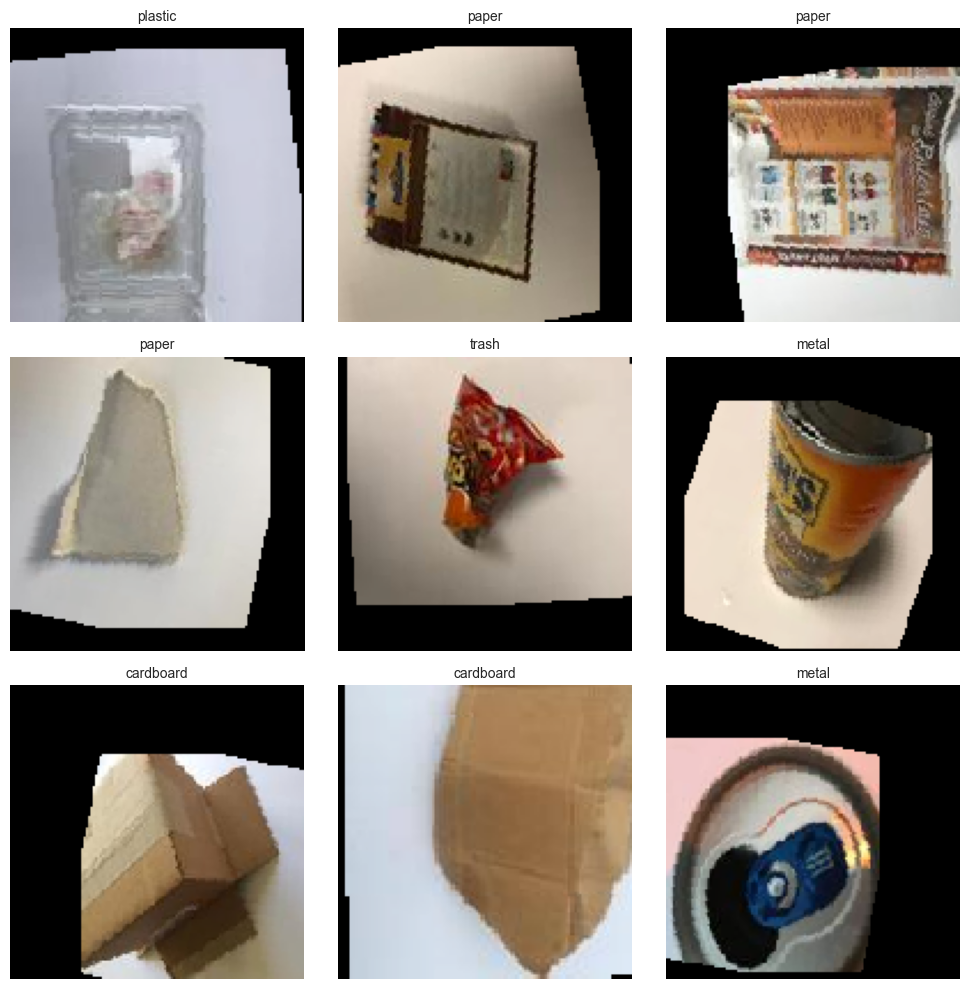

In [27]:
# Visualize a batch of training data (PyTorch)
NUM_IMAGES_TO_DISPLAY = 9
GRID_SHAPE = (3, 3)
PLOT_SIZE = (10, 10)
NORMALIZATION_MEAN = np.array([0.485, 0.456, 0.406])
NORMALIZATION_STD = np.array([0.229, 0.224, 0.225])

# Get a batch of images
images, labels = next(iter(train_loader_resnet))

# Create visualization
plt.figure(figsize=PLOT_SIZE)
for i in range(min(NUM_IMAGES_TO_DISPLAY, len(images))):
    # Prepare image
    img = images[i].permute(1, 2, 0).numpy()
    img = (img * NORMALIZATION_STD) + NORMALIZATION_MEAN
    img = np.clip(img, 0, 1)

    # Get class info
    class_idx = labels[i].item()
    class_name = train_dataset_resnet.classes[class_idx]

    # Plot
    plt.subplot(*GRID_SHAPE, i+1)
    plt.imshow(img)
    plt.title(class_name, fontsize=10)
    plt.axis('off')

plt.tight_layout()
plt.show()

In [28]:
def extract_resnet_embedding_pytorch(img_path, model, transform, device=None):
    """Extract feature embeddings from an image using a ResNet model.
    
    Args:
        img_path (str): Path to the input image file
        model (torch.nn.Module): Pretrained ResNet model
        transform (torchvision.transforms): Image transformations to apply
        device (str, optional): Device to run model on. Defaults to 'cuda' if available, else 'cpu'
    
    Returns:
        np.ndarray: Flattened feature vector, or None if error occurs
    """
    if device is None:
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

    try:
        # Load and transform image
        img = Image.open(img_path).convert('RGB')
        img_tensor = transform(img).unsqueeze(0).to(device)

        # Extract features
        with torch.no_grad():
            features = model(img_tensor)

        # Return flattened features as numpy array
        return features.flatten(start_dim=1).squeeze(0).cpu().numpy()

    except Exception as e:
        print(f"Error extracting ResNet embedding from {img_path}: {str(e)}")
        return None

In [35]:
# Feature Extraction and Preprocessing for Classical ML Models (PyTorch ResNet50)

# Initialize model
resnet50_model = torchvision.models.resnet50(weights='IMAGENET1K_V1')
resnet50_model = nn.Sequential(*list(resnet50_model.children())[:-1])
resnet50_model = resnet50_model.eval().to(device)

def extract_resnet_features(data_path='./dataset_split', img_size=128, test_size=0.2, random_state=42):
    """Extract and process ResNet50 features from image dataset.
    
    Args:
        data_path (str): Path to dataset directory
        img_size (int): Target image size (default: 128)
        test_size (float): Test set proportion (default: 0.2)
        random_state (int): Random seed (default: 42)
        
    Returns:
        tuple: (X_train, X_test, y_train, y_test, label_encoder)
    """
    # Configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    img_extensions = ('.jpg', '.png', '.jpeg')
    splits = ['train', 'test']

    # Define transforms
    transform = transforms.Compose([
        transforms.Resize((img_size, img_size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Extract embeddings
    embeddings = []
    labels = []

    for split_name in splits:
        split_dir = os.path.join(data_path, split_name)
        for class_name in os.listdir(split_dir):
            class_dir = os.path.join(split_dir, class_name)
            if not os.path.isdir(class_dir):
                continue

            img_files = [f for f in os.listdir(class_dir)
                         if f.lower().endswith(img_extensions)]

            for img_file in img_files:
                img_path = os.path.join(class_dir, img_file)
                emb = extract_resnet_embedding_pytorch(img_path, resnet50_model, transform, device)
                if emb is not None:
                    embeddings.append(emb.flatten())
                    labels.append(class_name)

    # Preprocess features
    le = LabelEncoder()
    y = le.fit_transform(labels)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(embeddings)

    # Dimensionality reduction
    pca = PCA(n_components=100)
    X_pca = pca.fit_transform(X_scaled)

    selector = SelectKBest(score_func=f_classif, k=50)
    X_features = selector.fit_transform(X_pca, y)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X_features, y,
        test_size=test_size,
        random_state=random_state,
        stratify=y
    )

    # Print summary
    print("\nFeature Extraction Summary:")
    print(f"- Total samples: {len(embeddings)}")
    print(f"- Classes: {len(le.classes_)}")
    print(f"- Train shape: {X_train.shape}")
    print(f"- Test shape: {X_test.shape}")

    return X_train, X_test, y_train, y_test, le

# Execute the pipeline
X_train_resnet, X_test_resnet, y_train_resnet, y_test_resnet, label_encoder = extract_resnet_features()


Feature Extraction Summary:
- Total samples: 2192
- Classes: 6
- Train shape: (1753, 50)
- Test shape: (439, 50)



---


# Milestone 3: Machine Learning Model Development and Optimization

### Classical Machine Learning Models



Logistic Regression Performance (ResNet Features):
Accuracy: 0.7768
Classification Report:
              precision    recall  f1-score   support

   cardboard       0.84      0.83      0.84        77
       glass       0.77      0.70      0.73        82
       metal       0.69      0.81      0.75        75
       paper       0.81      0.87      0.84       101
     plastic       0.78      0.75      0.77        81
       trash       0.67      0.43      0.53        23

    accuracy                           0.78       439
   macro avg       0.76      0.73      0.74       439
weighted avg       0.78      0.78      0.77       439


SVM (RBF) Performance (ResNet Features):
Accuracy: 0.8200
Classification Report:
              precision    recall  f1-score   support

   cardboard       0.96      0.86      0.90        77
       glass       0.78      0.76      0.77        82
       metal       0.74      0.89      0.81        75
       paper       0.81      0.93      0.87       101
     plastic

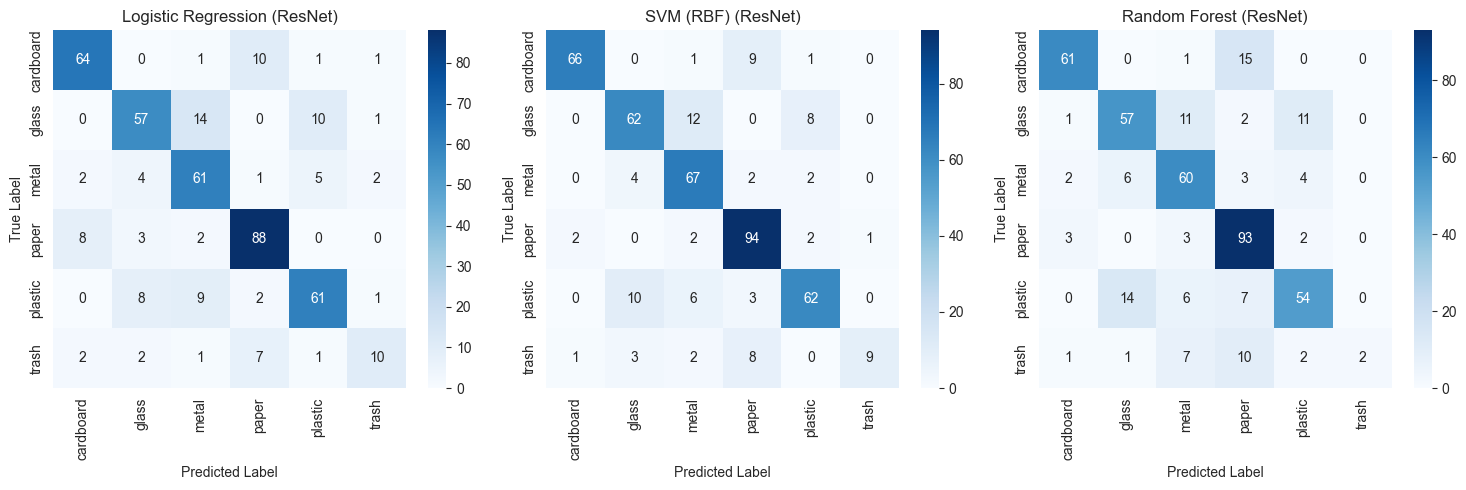

In [30]:
# Train and Evaluate Classical Machine Learning Models
models_resnet = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'SVM (RBF)': SVC(kernel='rbf', probability=True, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42)
}

# Train and evaluate each model
for name, model in models_resnet.items():
    # Train model
    model.fit(X_train_resnet, y_train_resnet)

    # Make predictions
    y_pred_resnet = model.predict(X_test_resnet)

    # Calculate metrics
    acc = accuracy_score(y_test_resnet, y_pred_resnet)
    class_report = classification_report(
        y_test_resnet,
        y_pred_resnet,
        target_names=label_encoder.classes_,
        digits=2
    )

    # Print results
    print(f"\n{name} Performance (ResNet Features):")
    print(f"Accuracy: {acc:.4f}")
    print("Classification Report:")
    print(class_report)

# Create confusion matrix plots
plt.figure(figsize=(15, 5))
for i, (name, model) in enumerate(models_resnet.items(), 1):
    y_pred_resnet = model.predict(X_test_resnet)
    cm = confusion_matrix(y_test_resnet, y_pred_resnet)

    plt.subplot(1, 3, i)
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        xticklabels=label_encoder.classes_,
        yticklabels=label_encoder.classes_,
        cmap='Blues'
    )
    plt.title(f'{name} (ResNet)')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')

plt.tight_layout()
plt.show()

### Hyperparameter Tuning

In [31]:
    # Hyperparameter Tuning (using ResNet features)
MODEL_CONFIGS = [
    {
        'name': 'Logistic Regression',
        'model': LogisticRegression(max_iter=1000, random_state=42),
        'param_grid': {
            'C': [0.01, 0.1, 1, 10],
            'penalty': ['l2'],
            'solver': ['lbfgs']
        }
    },
    {
        'name': 'SVM',
        'model': SVC(probability=True, random_state=42),
        'param_grid': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }
    },
    {
        'name': 'Random Forest',
        'model': RandomForestClassifier(random_state=42),
        'param_grid': {
            'n_estimators': [100, 200],
            'max_depth': [None, 10, 20]
        }
    }
]

# Perform tuning for each model
tuned_models = {}
for config in MODEL_CONFIGS:
    grid = GridSearchCV(
        estimator=config['model'],
        param_grid=config['param_grid'],
        cv=3,
        scoring='accuracy',
        n_jobs=-1,
        verbose=1
    )
    print(f"\nTuning {config['name']}...")
    grid.fit(X_train_resnet, y_train_resnet)
    tuned_models[config['name']] = grid

    # Print results
    print(f"Best {config['name']} (ResNet):")
    print(f"Parameters: {grid.best_params_}")
    print(f"Validation Accuracy: {grid.best_score_:.4f}\n")


Tuning Logistic Regression...
Fitting 3 folds for each of 4 candidates, totalling 12 fits
Best Logistic Regression (ResNet):
Parameters: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
Validation Accuracy: 0.7884


Tuning SVM...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best SVM (ResNet):
Parameters: {'C': 10, 'kernel': 'rbf'}
Validation Accuracy: 0.8266


Tuning Random Forest...
Fitting 3 folds for each of 6 candidates, totalling 18 fits
Best Random Forest (ResNet):
Parameters: {'max_depth': None, 'n_estimators': 200}
Validation Accuracy: 0.7690



### Ensemble Methods

Training Voting Classifier...
Voting Classifier training completed.

Voting Classifier Performance (ResNet Features)

Accuracy: 0.8269

Classification Report:
              precision    recall  f1-score   support

   cardboard     0.8947    0.8831    0.8889        77
       glass     0.8400    0.7683    0.8025        82
       metal     0.7363    0.8933    0.8072        75
       paper     0.8257    0.8911    0.8571       101
     plastic     0.8421    0.7901    0.8153        81
       trash     0.9167    0.4783    0.6286        23

    accuracy                         0.8269       439
   macro avg     0.8426    0.7840    0.7999       439
weighted avg     0.8330    0.8269    0.8243       439



<Figure size 1000x800 with 0 Axes>

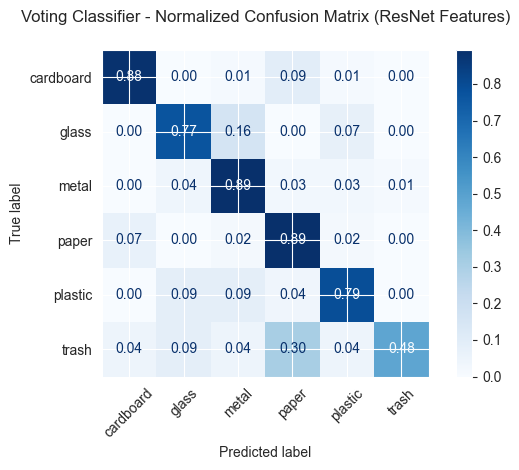


Additional Metrics:
Log Loss: 0.5639
Balanced Accuracy: 0.7840


In [32]:
# Ensemble Voting Classifier with ResNet Features
voting_clf_resnet = VotingClassifier(
    estimators=[
        ('lr', tuned_models['Logistic Regression'].best_estimator_),
        ('svm', tuned_models['SVM'].best_estimator_),
        ('rf', tuned_models['Random Forest'].best_estimator_)
    ],
    voting='soft',
    n_jobs=-1  # Enable parallel processing
)

# Train and evaluate
print("Training Voting Classifier...")
voting_clf_resnet.fit(X_train_resnet, y_train_resnet)
print("Voting Classifier training completed.\n")

# Generate predictions and metrics
y_pred_voting_resnet = voting_clf_resnet.predict(X_test_resnet)
y_proba_voting_resnet = voting_clf_resnet.predict_proba(X_test_resnet)

# Calculate evaluation metrics
acc_voting_resnet = accuracy_score(y_test_resnet, y_pred_voting_resnet)
class_report = classification_report(
    y_test_resnet,
    y_pred_voting_resnet,
    target_names=label_encoder.classes_,
    digits=4
)

# Print comprehensive results
print("="*60)
print(f"Voting Classifier Performance (ResNet Features)")
print("="*60)
print(f"\nAccuracy: {acc_voting_resnet:.4f}")
print("\nClassification Report:")
print(class_report)

# Generate and display confusion matrix
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay.from_estimator(
    voting_clf_resnet,
    X_test_resnet,
    y_test_resnet,
    display_labels=label_encoder.classes_,
    cmap='Blues',
    xticks_rotation=45,
    normalize='true',
    values_format='.2f'
)
plt.title("Voting Classifier - Normalized Confusion Matrix (ResNet Features)", pad=20)
plt.tight_layout()
plt.show()

# Additional metrics
print("\nAdditional Metrics:")
print(f"Log Loss: {log_loss(y_test_resnet, y_proba_voting_resnet):.4f}")
print(f"Balanced Accuracy: {balanced_accuracy_score(y_test_resnet, y_pred_voting_resnet):.4f}")

Stacking Classifier Accuracy (ResNet Features): 0.84
              precision    recall  f1-score   support

   cardboard       0.90      0.90      0.90        77
       glass       0.84      0.80      0.82        82
       metal       0.75      0.88      0.81        75
       paper       0.87      0.89      0.88       101
     plastic       0.86      0.80      0.83        81
       trash       0.87      0.57      0.68        23

    accuracy                           0.84       439
   macro avg       0.84      0.81      0.82       439
weighted avg       0.84      0.84      0.84       439



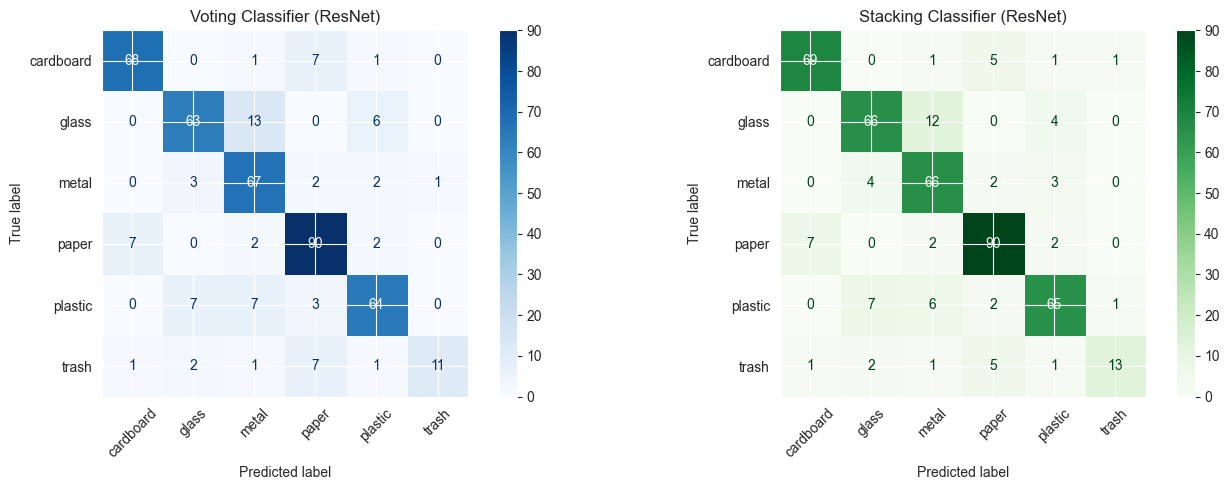

In [33]:
# Ensemble Methods: Stacking Classifier (using ResNet features)

stacking_clf_resnet = StackingClassifier(
    estimators=[
        ('lr', tuned_models['Logistic Regression'].best_estimator_),
        ('svm', tuned_models['SVM'].best_estimator_),
        ('rf', tuned_models['Random Forest'].best_estimator_)
    ],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)
stacking_clf_resnet.fit(X_train_resnet, y_train_resnet)
y_pred_stacking_resnet = stacking_clf_resnet.predict(X_test_resnet)
acc_stack_resnet = accuracy_score(y_test_resnet, y_pred_stacking_resnet)
print(f"Stacking Classifier Accuracy (ResNet Features): {acc_stack_resnet:.2f}")
print(classification_report(y_test_resnet, y_pred_stacking_resnet, target_names=label_encoder.classes_))

# Confusion Matrices for Ensemble Methods
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ConfusionMatrixDisplay.from_estimator(
    voting_clf_resnet, X_test_resnet, y_test_resnet, display_labels=label_encoder.classes_,
    cmap='Blues', xticks_rotation=45, ax=axes[0]
)
axes[0].set_title("Voting Classifier (ResNet)")
ConfusionMatrixDisplay.from_estimator(
    stacking_clf_resnet, X_test_resnet, y_test_resnet, display_labels=label_encoder.classes_,
    cmap='Greens', xticks_rotation=45, ax=axes[1]
)
axes[1].set_title("Stacking Classifier (ResNet)")
plt.tight_layout()
plt.show()

In [36]:
# Configuration
SAVE_DIR = 'saved_models'
os.makedirs(SAVE_DIR, exist_ok=True)

def save_model_with_metadata(model, model_name, model_type='pytorch'):
    """Save a model with metadata and return the save path."""
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{model_name}_{timestamp}.{'pth' if model_type == 'pytorch' else 'joblib'}"
    save_path = os.path.join(SAVE_DIR, filename)

    try:
        if model_type == 'pytorch':
            torch.save(model.state_dict(), save_path)
        else:
            joblib.dump(model, save_path)

        print(f"Successfully saved {model_name} to: {save_path}")
        return save_path
    except Exception as e:
        print(f"Error saving {model_name}: {str(e)}")
        return None

# Save PyTorch models
quick_model_path = save_model_with_metadata(quick_model, 'quick_cnn_model')
mobilenet_path = save_model_with_metadata(mobilenet_model.features, 'mobilenetv2_features')
resnet50_path = save_model_with_metadata(resnet50_model, 'resnet50_features')

# Save classical ML models
save_model_with_metadata(models_resnet, 'classical_ml_models_resnet', 'joblib')
save_model_with_metadata(tuned_models['Logistic Regression'], 'grid_lr_resnet', 'joblib')
save_model_with_metadata(tuned_models['SVM'], 'grid_svm_resnet', 'joblib')
save_model_with_metadata(tuned_models['Random Forest'], 'grid_rf_resnet', 'joblib')

# Save ensemble models
save_model_with_metadata(voting_clf_resnet, 'voting_clf_resnet', 'joblib')
save_model_with_metadata(stacking_clf_resnet, 'stacking_clf_resnet', 'joblib')

# Save label encoders and other metadata
joblib.dump(label_encoder, os.path.join(SAVE_DIR, 'label_encoder.joblib'))
print("Label encoders saved.")

# Create a README file with model information
with open(os.path.join(SAVE_DIR, 'README.md'), 'w') as f:
    f.write("# Model Storage Information\n\n")
    f.write(f"## Saved on {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n\n")
    f.write("### Models Included:\n")
    f.write("- Quick CNN Model\n")
    f.write("- MobileNetV2 Feature Extractor\n")
    f.write("- ResNet50 Feature Extractor\n")
    f.write("- Classical ML Models (Logistic Regression, SVM, Random Forest)\n")
    f.write("- Tuned Classical ML Models\n")
    f.write("- Voting Classifier\n")
    f.write("- Stacking Classifier\n")
    f.write("- Label Encoders\n")
print("README file created in saved_models directory.")

Successfully saved quick_cnn_model to: saved_models\quick_cnn_model_20250512_040632.pth
Successfully saved mobilenetv2_features to: saved_models\mobilenetv2_features_20250512_040632.pth
Successfully saved resnet50_features to: saved_models\resnet50_features_20250512_040632.pth
Successfully saved classical_ml_models_resnet to: saved_models\classical_ml_models_resnet_20250512_040633.joblib
Successfully saved grid_lr_resnet to: saved_models\grid_lr_resnet_20250512_040633.joblib
Successfully saved grid_svm_resnet to: saved_models\grid_svm_resnet_20250512_040633.joblib
Successfully saved grid_rf_resnet to: saved_models\grid_rf_resnet_20250512_040633.joblib
Successfully saved voting_clf_resnet to: saved_models\voting_clf_resnet_20250512_040633.joblib
Successfully saved stacking_clf_resnet to: saved_models\stacking_clf_resnet_20250512_040634.joblib
Label encoders saved.
README file created in saved_models directory.


### Neural Network Models

In [38]:
class SimpleANN(nn.Module):
    def __init__(self, input_size, hidden_units, num_classes, dropout_rate=0.2):
        """Initialize a simple feedforward neural network.
        
        Args:
            input_size (int): Size of input features (flattened)
            hidden_units (list): List of integers specifying hidden layer sizes
            num_classes (int): Number of output classes
            dropout_rate (float): Dropout probability (default: 0.2)
        """
        super().__init__()

        # Input validation
        if not isinstance(hidden_units, (list, tuple)):
            raise ValueError("hidden_units must be a list or tuple of integers")
        if not all(isinstance(x, int) and x > 0 for x in hidden_units):
            raise ValueError("All hidden units must be positive integers")

        layers = []
        in_features = input_size

        # Build hidden layers
        for i, units in enumerate(hidden_units):
            layers.append(nn.Linear(in_features, units))
            layers.append(nn.BatchNorm1d(units))  # Added batch normalization
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))  # Added dropout
            in_features = units

        # Output layer
        layers.append(nn.Linear(in_features, num_classes))

        self.network = nn.Sequential(*layers)

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights using Kaiming initialization."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """Forward pass of the network.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, *)
            
        Returns:
            torch.Tensor: Output logits
        """
        x = x.view(x.size(0), -1)  # Flatten input
        return self.network(x)

# Determine input size safely
def get_input_size(dataset):
    """Get flattened input size from dataset."""
    try:
        sample = next(iter(DataLoader(dataset, batch_size=1)))[0]
        return sample.view(-1).shape[0]
    except Exception as e:
        raise RuntimeError(f"Could not determine input size: {str(e)}")

# Initialize model
try:
    flat_input_size = get_input_size(train_dataset)
    ann_model = SimpleANN(
        input_size=flat_input_size,
        hidden_units=[128, 64],
        num_classes=num_classes,
        dropout_rate=0.3  # Slightly higher dropout for regularization
    )
    print(f"Initialized ANN model with input size {flat_input_size}")
except Exception as e:
    print(f"Error initializing ANN model: {str(e)}")

Initialized ANN model with input size 49152


In [39]:
class CNN(nn.Module):
    def __init__(self, num_classes, img_size=128, dropout_rate=0.3):
        """Initialize a CNN model for image classification.
        
        Args:
            num_classes (int): Number of output classes
            img_size (int): Input image size (default: 128)
            dropout_rate (float): Dropout probability (default: 0.3)
        """
        super().__init__()

        # Feature extraction layers
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64), 
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Calculate flattened size
        self.flatten = nn.Flatten()
        flattened_size = 64 * (img_size // 4) * (img_size // 4)

        # Classification head
        self.classifier = nn.Sequential(
            nn.Linear(flattened_size, 128),
            nn.BatchNorm1d(128),  # Added batch normalization
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),  # Added dropout
            nn.Linear(128, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights using Kaiming initialization."""
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        """Forward pass of the network.
        
        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, 3, img_size, img_size)
            
        Returns:
            torch.Tensor: Output logits
        """
        x = self.features(x)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

# Initialize model
cnn_model = CNN(
    num_classes=num_classes,
    img_size=128,  
    dropout_rate=0.3  
)

In [40]:
def initialize_googlenet(num_classes, pretrained=True, freeze_backbone=False):
    """Initialize and configure a GoogLeNet model for transfer learning.
    
    Args:
        num_classes (int): Number of output classes
        pretrained (bool): Whether to use pretrained weights (default: True)
        freeze_backbone (bool): Whether to freeze feature extractor (default: False)
        
    Returns:
        torch.nn.Module: Configured GoogLeNet model
    """
    try:
        # Load pretrained GoogLeNet
        model = models.googlenet(weights='IMAGENET1K_V1' if pretrained else None)

        # Freeze backbone if required
        if freeze_backbone:
            for param in model.parameters():
                param.requires_grad = False

        # Modify the final fully connected layer
        in_features = model.fc.in_features
        model.fc = nn.Linear(in_features, num_classes)

        # Modify auxiliary classifiers if they exist
        if hasattr(model, 'aux1') and model.aux1 is not None:
            model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
        if hasattr(model, 'aux2') and model.aux2 is not None:
            model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)

        # Initialize new layers properly
        nn.init.kaiming_normal_(model.fc.weight, mode='fan_out', nonlinearity='relu')
        if model.fc.bias is not None:
            nn.init.constant_(model.fc.bias, 0)

        print(f"Initialized GoogLeNet model with {num_classes} output classes")
        print(f"Backbone {'frozen' if freeze_backbone else 'trainable'}")
        return model

    except Exception as e:
        print(f"Error initializing GoogLeNet: {str(e)}")
        raise

# Example usage
googlenet_model = initialize_googlenet(
    num_classes=10,  # Your number of classes
    pretrained=True,
    freeze_backbone=True  # Set to False if you want to fine-tune the entire model
)

Initialized GoogLeNet model with 10 output classes
Backbone frozen


In [14]:
def train_epoch(model, dataloader, criterion, optimizer, device, grad_clip=None):
    """Train model for one epoch with optional gradient clipping."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(dataloader, desc="Training", leave=False):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()

        # Gradient clipping if specified
        if grad_clip is not None:
            torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)

        optimizer.step()

        # Update metrics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total

def evaluate_epoch(model, dataloader, criterion, device):
    """Evaluate model on validation/test set."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in tqdm(dataloader, desc="Evaluating", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    return running_loss / total, correct / total

def train_and_evaluate(model, train_loader, val_loader, criterion, optimizer, device,
                       epochs=50, patience=5, scheduler=None, grad_clip=None):
    """Train model with early stopping and optional learning rate scheduling."""
    history = {
        'train_loss': [], 'val_loss': [],
        'train_acc': [], 'val_acc': []
    }
    best_val_loss = float('inf')
    epochs_no_improve = 0
    best_model_state = deepcopy(model.state_dict())

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, device, grad_clip
        )
        val_loss, val_acc = evaluate_epoch(model, val_loader, criterion, device)

        # Update history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc)
        history['val_acc'].append(val_acc)

        # Step the learning rate scheduler if provided
        if scheduler is not None:
            if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_loss)
            else:
                scheduler.step()

        # Early stopping check
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
            best_model_state = deepcopy(model.state_dict())
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f'\nEarly stopping after {epoch+1} epochs!')
                model.load_state_dict(best_model_state)
                break

        # Print epoch summary
        lr = optimizer.param_groups[0]['lr']
        print(f'Epoch {epoch+1}/{epochs}: '
              f'Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | '
              f'Train Acc: {train_acc:.4f} | Val Acc: {val_acc:.4f} | '
              f'LR: {lr:.2e}')

    return history, best_model_state

def cross_validate(model_type, dataset, val_dataset, folds=5, epochs=50,
                   learning_rate=0.001, patience=5, batch_size=32,
                   device=None, model_args=None):
    """Perform k-fold cross validation with consistent validation set."""
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    if model_args is None:
        model_args = {}

    kf = KFold(n_splits=folds, shuffle=True, random_state=42)
    fold_results = []
    best_models = []

    for fold, (train_idx, _) in enumerate(kf.split(range(len(dataset)))):
        print(f"\n{'='*40}")
        print(f"Fold {fold+1}/{folds}")
        print(f"{'='*40}")

        # Create data loaders
        train_sampler = SubsetRandomSampler(train_idx)
        train_loader = DataLoader(
            dataset, batch_size=batch_size, sampler=train_sampler,
            num_workers=4, pin_memory=True
        )
        val_loader = DataLoader(
            val_dataset, batch_size=batch_size,
            num_workers=4, pin_memory=True
        )

        # Initialize model
        if model_type.__name__ == 'SimpleANN':
            model = SimpleANN(**model_args).to(device)
        elif model_type.__name__ == 'CNN':
            model = CNN(**model_args).to(device)
        elif model_type.__name__ == 'GoogLeNet':
            model = initialize_googlenet(**model_args).to(device)
        else:
            raise ValueError(f"Unsupported model type: {model_type.__name__}")

        # Training setup
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=learning_rate)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            optimizer, 'min', patience=patience//2, factor=0.5, verbose=True
        )

        # Train and evaluate
        history, best_state = train_and_evaluate(
            model, train_loader, val_loader, criterion, optimizer, device,
            epochs=epochs, patience=patience, scheduler=scheduler,
            grad_clip=1.0  # Mild gradient clipping
        )

        # Store results
        model.load_state_dict(best_state)
        _, val_acc = evaluate_epoch(model, val_loader, criterion, device)
        fold_results.append(val_acc)
        best_models.append(deepcopy(model.state_dict()))

        print(f"\nFold {fold+1} Results:")
        print(f"- Best Val Accuracy: {val_acc:.4f}")
        print(f"- Final LR: {optimizer.param_groups[0]['lr']:.2e}")

    # Final summary
    mean_val_acc = np.mean(fold_results)
    std_val_acc = np.std(fold_results)

    print(f"\n{'='*40}")
    print(f"Cross-Validation Complete ({folds} folds)")
    print(f"{'='*40}")
    print(f"Mean Val Accuracy: {mean_val_acc:.4f} ± {std_val_acc:.4f}")

    return {
        'fold_accuracies': fold_results,
        'best_model_states': best_models,
        'mean_accuracy': mean_val_acc,
        'std_accuracy': std_val_acc
    }

In [ ]:
# Cross-Validation
def run_comprehensive_cv(train_dataset, val_dataset, num_classes, img_size=128):
    """Run cross-validation for all model types with optimal settings."""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"\n{'='*60}")
    print(f"Starting Comprehensive Cross-Validation on {device}")
    print(f"{'='*60}\n")

    # Configuration for each model type
    model_configs = [
        {
            'name': 'SimpleANN',
            'type': SimpleANN,
            'args': {
                'input_size': img_size * img_size * 3,  # Flattened image size
                'hidden_units': [128, 64],
                'num_classes': num_classes,
                'dropout_rate': 0.3
            },
            'train_params': {
                'epochs': 30,
                'learning_rate': 0.001,
                'batch_size': 64,
                'patience': 5
            }
        },
        {
            'name': 'CNN',
            'type': CNN,
            'args': {
                'num_classes': num_classes,
                'img_size': img_size,
                'dropout_rate': 0.3
            },
            'train_params': {
                'epochs': 30,
                'learning_rate': 0.001,
                'batch_size': 32,
                'patience': 5
            }
        },
        {
            'name': 'GoogLeNet',
            'type': models.GoogLeNet,
            'args': {
                'num_classes': num_classes,
                'pretrained': True,
                'freeze_backbone': True  # Freeze feature extractor
            },
            'train_params': {
                'epochs': 15,
                'learning_rate': 0.0001,  # Smaller LR for fine-tuning
                'batch_size': 32,
                'patience': 3
            }
        }
    ]

    results = {}
    final_models = {}

    for config in model_configs:
        print(f"\n{'='*40}")
        print(f"Running {config['name']} Cross-Validation")
        print(f"{'='*40}")

        cv_result = cross_validate(
            model_type=config['type'],
            dataset=train_dataset,
            val_dataset=val_dataset,
            folds=5,
            device=device,
            model_args=config['args'],
            **config['train_params']
        )

        results[config['name']] = cv_result
        final_models[config['name']] = cv_result['best_model_states'][-1]

        # Print summary
        print(f"\n{config['name']} CV Results:")
        print(f"- Mean Val Accuracy: {cv_result['mean_accuracy']:.4f}")
        print(f"- Std Dev: {cv_result['std_accuracy']:.4f}")
        print(f"- Fold Accuracies: {[f'{acc:.4f}' for acc in cv_result['fold_accuracies']]}")

    # Comparative analysis
    print("\n\n" + "="*60)
    print("Cross-Validation Summary")
    print("="*60)
    for model_name, res in results.items():
        print(f"{model_name:<12} | Mean Acc: {res['mean_accuracy']:.4f} ± {res['std_accuracy']:.4f}")

    return results, final_models

# Execute the comprehensive cross-validation
all_results, all_models = run_comprehensive_cv(
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    num_classes=num_classes,
    img_size=128
)

In [11]:
def evaluate_on_test_with_metrics(model, test_loader, device, class_names, model_name=""):
    """Comprehensive evaluation of model on test set with multiple metrics."""
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []

    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc=f"Evaluating {model_name}", leave=False):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            probs = F.softmax(outputs, dim=1)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())

    # Calculate metrics
    accuracy = accuracy_score(all_labels, all_preds)
    balanced_acc = balanced_accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, target_names=class_names, digits=4)
    cm = confusion_matrix(all_labels, all_preds)
    # Handle binary vs. multi-class for ROC AUC
    if len(class_names) > 2:
        try:
            roc_auc = roc_auc_score(all_labels, all_probs, multi_class='ovr')
        except ValueError:
            print(f"Warning: ROC AUC calculation failed for multi-class '{model_name}'.")
            roc_auc = np.nan
    elif len(class_names) == 2:
        roc_auc = roc_auc_score(all_labels, np.array(all_probs)[:, 1])
    else:
        roc_auc = np.nan # Only one class

    return {
        'accuracy': accuracy,
        'balanced_accuracy': balanced_acc,
        'roc_auc': roc_auc,
        'classification_report': report,
        'confusion_matrix': cm,
        'predictions': all_preds,
        'probabilities': all_probs,
        'true_labels': all_labels
    }

def plot_confusion_matrix(cm, class_names, model_name, cmap='Blues'):
    """Plot normalized confusion matrix with better formatting."""
    plt.figure(figsize=(12, 10))
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap=cmap,
                xticklabels=class_names, yticklabels=class_names,
                cbar=False, linewidths=0.5, linecolor='gray')

    plt.title(f'{model_name} - Normalized Confusion Matrix', pad=20, fontsize=14)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.ylabel('True Label', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

def evaluate_all_models(models_dict, test_loader, device, class_names, img_size=128, num_classes=None):
    """Evaluate multiple models and generate comparative report."""
    results = {}

    for model_name, model_state in models_dict.items():
        print(f"\n{'='*60}")
        print(f"Evaluating {model_name} on Test Set")
        print(f"{'='*60}")

        # Instantiate the model based on the name and load the best state
        if model_name == 'SimpleANN':
            model = SimpleANN(input_size=img_size * img_size * 3,
                              hidden_units=[128, 64],
                              num_classes=num_classes,
                              dropout_rate=0.3).to(device)
        elif model_name == 'CNN':
            # Create the CNN with the exact architecture used during training
            model = CNN(num_classes=num_classes,
                        img_size=img_size,
                        dropout_rate=0.3).to(device)
        elif model_name == 'CNN-RNN':
            model = CNNRNNClassifier(num_classes=num_classes).to(device)
        elif model_name == 'GoogLeNet':
            model = initialize_googlenet(num_classes=num_classes).to(device)
        else:
            print(f"Unknown model name: {model_name}. Skipping.")
            continue

        try:
            # Try loading with strict=False first
            model.load_state_dict(model_state, strict=False)
            print(f"Successfully loaded {model_name} with strict=False")
        except Exception as e:
            print(f"Error loading {model_name}: {str(e)}")
            continue

        model.eval()  # Set to evaluation mode

        eval_results = evaluate_on_test_with_metrics(model, test_loader, device, class_names, model_name)
        results[model_name] = eval_results

        # Print metrics
        print(f"\n{model_name} Test Metrics:")
        print(f"- Accuracy: {eval_results['accuracy']:.4f}")
        print(f"- Balanced Accuracy: {eval_results['balanced_accuracy']:.4f}")
        if 'roc_auc' in eval_results:
            print(f"- ROC AUC: {eval_results['roc_auc']:.4f}")
        print("\nClassification Report:")
        print(eval_results['classification_report'])

        # Plot confusion matrix
        plot_confusion_matrix(eval_results['confusion_matrix'], class_names, model_name)

    # Comparative analysis
    print("\n\n" + "="*60)
    print("Model Comparison Summary")
    print("="*60)
    print(f"{'Model':<15} {'Accuracy':<10} {'Balanced Acc':<12} {'ROC AUC':<10}")
    for model_name, res in results.items():
        roc_auc_str = f"{res['roc_auc']:.4f}" if 'roc_auc' in res else "N/A"
        print(f"{model_name:<15} {res['accuracy']:.4f}     {res['balanced_accuracy']:.4f}       {roc_auc_str}")

    return results

In [ ]:
# Run comprehensive evaluation using the final_models from cross-validation
if 'all_models' in locals():
    test_results = evaluate_all_models(
        models_dict=all_models,
        test_loader=test_loader,
        device=device,
        class_names=class_names,
        img_size=128,
        num_classes=num_classes # Ensure num_classes is defined
    )
else:
    print("Error: Cross-validation was not run. 'all_models' is not defined.")

### Hyperparameter Tuning with Optuna

In [15]:
#CNN Tuning
def objective_cnn(trial):
    """Optuna objective function for CNN hyperparameter optimization."""
    # Define hyperparameters to optimize with more sophisticated suggestions
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    num_filters_1 = trial.suggest_int("num_filters_1", 16, 128, step=16)
    num_filters_2 = trial.suggest_int("num_filters_2", 32, 256, step=32)
    fc1_units = trial.suggest_int("fc1_units", 64, 512, step=64)
    dropout_rate = trial.suggest_float("dropout", 0.1, 0.5, step=0.1)
    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)

    # Create data loaders with suggested batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Define the CNN model with suggested hyperparameters
    class TunedCNN(nn.Module):
        def __init__(self, num_classes, num_filters_1, num_filters_2, fc1_units, dropout_rate):
            super().__init__()
            self.features = nn.Sequential(
                nn.Conv2d(3, num_filters_1, kernel_size=3, padding=1),
                nn.BatchNorm2d(num_filters_1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),

                nn.Conv2d(num_filters_1, num_filters_2, kernel_size=3, padding=1),
                nn.BatchNorm2d(num_filters_2),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )

            self.classifier = nn.Sequential(
                nn.Flatten(),
                nn.Linear(num_filters_2 * (img_size // 4) * (img_size // 4), fc1_units),
                nn.BatchNorm1d(fc1_units),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate),
                nn.Linear(fc1_units, num_classes)
            )

            # Initialize weights
            self._initialize_weights()

        def _initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Conv2d):
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
                elif isinstance(m, nn.Linear):
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    nn.init.constant_(m.bias, 0)

        def forward(self, x):
            x = self.features(x)
            x = self.classifier(x)
            return x

    # Initialize model and training components
    model = TunedCNN(num_classes, num_filters_1, num_filters_2, fc1_units, dropout_rate).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2, factor=0.5)

    # Training loop with early stopping
    epochs = 15
    best_val_accuracy = 0.0
    patience = 3
    no_improve = 0

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = evaluate_epoch(model, val_loader, criterion, device)
        scheduler.step(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break

    return best_val_accuracy

# Train the best CNN model with full epochs
class BestTunedCNN(nn.Module):
    def __init__(self, num_classes, params):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, params['num_filters_1'], kernel_size=3, padding=1),
            nn.BatchNorm2d(params['num_filters_1']),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(params['num_filters_1'], params['num_filters_2'], kernel_size=3, padding=1),
            nn.BatchNorm2d(params['num_filters_2']),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(params['num_filters_2'] * (img_size // 4) * (img_size // 4), params['fc1_units']),
            nn.BatchNorm1d(params['fc1_units']),
            nn.ReLU(inplace=True),
            nn.Dropout(params['dropout']),
            nn.Linear(params['fc1_units'], num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [10]:
# Create and run the study
study_cnn = optuna.create_study(direction="maximize")
study_cnn.enqueue_trial({
    'lr': 0.001,
    'num_filters_1': 32,
    'num_filters_2': 64,
    'fc1_units': 128,
    'dropout': 0.2,
    'batch_size': 64,
    'weight_decay': 1e-4
})

[I 2025-05-12 16:59:14,313] A new study created in memory with name: no-name-2a25ddcd-a161-4347-9b0b-fd0c5aa7199b


In [16]:
# Optimize with pruning
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
study_cnn.optimize(objective_cnn, n_trials=50, timeout=3600, callbacks=[lambda study, trial: print(f"Trial {trial.number} completed with value: {trial.value}")])

# Print results
print("\nBest CNN hyperparameters:", study_cnn.best_params)
print("Best validation accuracy:", study_cnn.best_value)

# Visualization
optuna.visualization.plot_optimization_history(study_cnn).show()
optuna.visualization.plot_param_importances(study_cnn).show()

# Initialize and train the best model
best_cnn_model = BestTunedCNN(num_classes, study_cnn.best_params).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(best_cnn_model.parameters(),
                        lr=study_cnn.best_params['lr'],
                        weight_decay=study_cnn.best_params['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)

# Full training with best parameters
epochs = 30
best_val_acc = 0.0
train_loader = DataLoader(train_dataset, batch_size=study_cnn.best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=study_cnn.best_params['batch_size'])

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(best_cnn_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate_epoch(best_cnn_model, val_loader, criterion, device)
    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(best_cnn_model.state_dict(), 'saved_models/best_cnn_model.pth')

    print(f'Epoch {epoch+1}/{epochs}: '
          f'Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} | '
          f'LR: {optimizer.param_groups[0]["lr"]:.2e}')

# Load best model and evaluate
best_cnn_model.load_state_dict(torch.load('saved_models/best_cnn_model.pth'))
cnn_test_results = evaluate_on_test_with_metrics(best_cnn_model, test_loader, device, class_names, "Best Tuned CNN")

# Enhanced visualization
plot_confusion_matrix(cnn_test_results['confusion_matrix'], class_names, "Best Tuned CNN", cmap='plasma')

[I 2025-05-12 17:04:35,001] Trial 1 finished with value: 0.546875 and parameters: {'lr': 0.000813913707403914, 'num_filters_1': 32, 'num_filters_2': 224, 'fc1_units': 512, 'dropout': 0.1, 'batch_size': 128, 'weight_decay': 5.522566864018016e-05}. Best is trial 1 with value: 0.546875.


Trial 1 completed with value: 0.546875


[I 2025-05-12 17:05:52,967] Trial 2 finished with value: 0.5234375 and parameters: {'lr': 0.004502601387522683, 'num_filters_1': 96, 'num_filters_2': 192, 'fc1_units': 256, 'dropout': 0.30000000000000004, 'batch_size': 64, 'weight_decay': 0.0004119273358050283}. Best is trial 1 with value: 0.546875.


Trial 2 completed with value: 0.5234375


[I 2025-05-12 17:08:26,446] Trial 3 finished with value: 0.59375 and parameters: {'lr': 7.922148860108554e-05, 'num_filters_1': 128, 'num_filters_2': 64, 'fc1_units': 128, 'dropout': 0.5, 'batch_size': 32, 'weight_decay': 1.1669807446370489e-06}. Best is trial 3 with value: 0.59375.


Trial 3 completed with value: 0.59375


[W 2025-05-12 17:17:54,023] Trial 4 failed with parameters: {'lr': 3.727761125766858e-05, 'num_filters_1': 96, 'num_filters_2': 192, 'fc1_units': 128, 'dropout': 0.4, 'batch_size': 128, 'weight_decay': 0.0007661024172384883} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "C:\Users\nagy1\AppData\Local\Programs\Python\Python312\Lib\site-packages\optuna\study\_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "C:\Users\nagy1\AppData\Local\Temp\ipykernel_7384\26956131.py", line 73, in objective_cnn
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
                            ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\nagy1\AppData\Local\Temp\ipykernel_7384\3468920096.py", line 23, in train_epoch
    running_loss += loss.item() * inputs.size(0)
                    ^^^^^^^^^^^
KeyboardInterrupt
[W 2025-05-

In [6]:
#ANN Tuning
def objective_ann(trial):
    """Optuna objective function for ANN hyperparameter optimization."""
    # Define hyperparameters to optimize with expanded ranges
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=True)
    num_hidden_1 = trial.suggest_int("num_hidden_1", 64, 512, step=64)
    num_hidden_2 = trial.suggest_int("num_hidden_2", 32, 256, step=32)
    dropout_rate = trial.suggest_float("dropout", 0.1, 0.5, step=0.1)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [64, 128, 256])

    # Create data loaders with suggested batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    class TunedANN(nn.Module):
        def __init__(self, input_size, hidden_units, num_classes, dropout_rate):
            super().__init__()
            layers = []
            in_features = input_size

            # Dynamically create hidden layers
            for i, units in enumerate(hidden_units):
                layers.extend([
                    nn.Linear(in_features, units),
                    nn.BatchNorm1d(units),
                    nn.ReLU(inplace=True),
                    nn.Dropout(dropout_rate)
                ])
                in_features = units

            layers.append(nn.Linear(in_features, num_classes))
            self.network = nn.Sequential(*layers)
            self._initialize_weights()

        def _initialize_weights(self):
            for m in self.modules():
                if isinstance(m, nn.Linear):
                    nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                    if m.bias is not None:
                        nn.init.constant_(m.bias, 0)

        def forward(self, x):
            return self.network(x.view(x.size(0), -1))

    # Initialize model with dynamic architecture
    model = TunedANN(
        flat_input_size,
        [num_hidden_1, num_hidden_2],
        num_classes,
        dropout_rate
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)

    # Training with early stopping
    epochs = 15
    best_val_accuracy = 0.0
    patience = 3
    no_improve = 0

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = evaluate_epoch(model, val_loader, criterion, device)
        scheduler.step(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break

    return best_val_accuracy

# Train the best ANN model with full epochs
class BestTunedANN(nn.Module):
    def __init__(self, input_size, hidden_units, num_classes, dropout_rate):
        super().__init__()
        layers = []
        in_features = input_size

        for units in hidden_units:
            layers.extend([
                nn.Linear(in_features, units),
                nn.BatchNorm1d(units),
                nn.ReLU(inplace=True),
                nn.Dropout(dropout_rate)
            ])
            in_features = units

        layers.append(nn.Linear(in_features, num_classes))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x.view(x.size(0), -1))

In [ ]:
# Create and run the study
study_ann = optuna.create_study(direction="maximize")
study_ann.enqueue_trial({
    'lr': 0.001,
    'num_hidden_1': 128,
    'num_hidden_2': 64,
    'dropout': 0.2,
    'weight_decay': 1e-4,
    'batch_size': 128
})

# Optimize with pruning
pruner = optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=5)
study_ann.optimize(objective_ann, n_trials=20, timeout=3600)

# Print results
print("\nBest ANN hyperparameters:", study_ann.best_params)
print("Best validation accuracy:", study_ann.best_value)

# Visualization
optuna.visualization.plot_optimization_history(study_ann).show()
optuna.visualization.plot_param_importances(study_ann).show()

# Initialize and train the best model
best_params = study_ann.best_params
best_ann_model = BestTunedANN(
    flat_input_size,
    [best_params['num_hidden_1'], best_params['num_hidden_2']],
    num_classes,
    best_params['dropout']
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(best_ann_model.parameters(),
                        lr=best_params['lr'],
                        weight_decay=best_params['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)

# Full training with best parameters
epochs = 30
best_val_acc = 0.0
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'])

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(best_ann_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate_epoch(best_ann_model, val_loader, criterion, device)
    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(best_ann_model.state_dict(), 'saved_models/best_ann_model.pth')

    print(f'Epoch {epoch+1}/{epochs}: '
          f'Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} | '
          f'LR: {optimizer.param_groups[0]["lr"]:.2e}')

# Load best model and evaluate
best_ann_model.load_state_dict(torch.load('saved_models/best_ann_model.pth'))
ann_test_results = evaluate_on_test_with_metrics(best_ann_model, test_loader, device, class_names, "Best Tuned ANN")

# Enhanced visualization
plot_confusion_matrix(ann_test_results['confusion_matrix'], class_names, "Best Tuned ANN", cmap='viridis')

In [7]:
#Pretrained Model Tuning
def objective_googlenet(trial):
    """Optuna objective function for GoogLeNet hyperparameter optimization."""
    # Define hyperparameters to optimize with expanded ranges
    lr = trial.suggest_float("lr", 1e-6, 1e-3, log=True)
    dropout_rate = trial.suggest_float("dropout", 0.1, 0.5, step=0.1)
    weight_decay = trial.suggest_float("weight_decay", 1e-6, 1e-3, log=True)
    batch_size = trial.suggest_categorical("batch_size", [16, 32, 64])
    freeze_backbone = trial.suggest_categorical("freeze_backbone", [True, False])

    # Create data loaders with suggested batch size
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model
    model = models.googlenet(weights='IMAGENET1K_V1')

    # Freeze backbone if specified
    if freeze_backbone:
        for param in model.parameters():
            param.requires_grad = False

    # Modify classifier head
    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(dropout_rate),
        nn.Linear(num_ftrs, num_classes)
    )

    # Modify auxiliary classifiers if they exist
    if hasattr(model, 'aux1') and model.aux1 is not None:
        model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
    if hasattr(model, 'aux2') and model.aux2 is not None:
        model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)

    model.to(device)

    # Training setup
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=2)

    # Training with early stopping
    epochs = 10
    best_val_accuracy = 0.0
    patience = 3
    no_improve = 0

    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_accuracy = evaluate_epoch(model, val_loader, criterion, device)
        scheduler.step(val_accuracy)

        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            no_improve = 0
        else:
            no_improve += 1
            if no_improve >= patience:
                break

    return best_val_accuracy

# Train the best GoogLeNet model with full epochs
def initialize_best_googlenet(params, num_classes):
    """Initialize GoogLeNet with best parameters."""
    model = models.googlenet(weights='IMAGENET1K_V1')

    if params['freeze_backbone']:
        for param in model.parameters():
            param.requires_grad = False

    num_ftrs = model.fc.in_features
    model.fc = nn.Sequential(
        nn.Dropout(params['dropout']),
        nn.Linear(num_ftrs, num_classes)
    )

    # Modify auxiliary classifiers
    if hasattr(model, 'aux1') and model.aux1 is not None:
        model.aux1.fc2 = nn.Linear(model.aux1.fc2.in_features, num_classes)
    if hasattr(model, 'aux2') and model.aux2 is not None:
        model.aux2.fc2 = nn.Linear(model.aux2.fc2.in_features, num_classes)

    return model

In [ ]:
# Create and run the study
study_googlenet = optuna.create_study(direction="maximize")
study_googlenet.enqueue_trial({
    'lr': 1e-4,
    'dropout': 0.4,
    'weight_decay': 1e-4,
    'batch_size': 32,
    'freeze_backbone': True
})

# Optimize with pruning
pruner = optuna.pruners.MedianPruner(n_startup_trials=3, n_warmup_steps=3)
study_googlenet.optimize(objective_googlenet, n_trials=15, timeout=3600)

# Print results
print("\nBest GoogLeNet hyperparameters:", study_googlenet.best_params)
print("Best validation accuracy:", study_googlenet.best_value)

# Visualization
optuna.visualization.plot_optimization_history(study_googlenet).show()
optuna.visualization.plot_param_importances(study_googlenet).show()

# Initialize and train the best model
best_params = study_googlenet.best_params
best_googlenet_model = initialize_best_googlenet(best_params, num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(best_googlenet_model.parameters(),
                        lr=best_params['lr'],
                        weight_decay=best_params['weight_decay'])
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max', patience=3)

# Full training with best parameters
epochs = 20
best_val_acc = 0.0
train_loader = DataLoader(train_dataset, batch_size=best_params['batch_size'], shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=best_params['batch_size'])

for epoch in range(epochs):
    train_loss, train_acc = train_epoch(best_googlenet_model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = evaluate_epoch(best_googlenet_model, val_loader, criterion, device)
    scheduler.step(val_acc)

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(best_googlenet_model.state_dict(), 'saved_models/best_googlenet_model.pth')

    print(f'Epoch {epoch+1}/{epochs}: '
          f'Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f} | '
          f'LR: {optimizer.param_groups[0]["lr"]:.2e}')

# Load best model and evaluate
best_googlenet_model.load_state_dict(torch.load('saved_models/best_googlenet_model.pth'))
googlenet_test_results = evaluate_on_test_with_metrics(best_googlenet_model, test_loader, device, class_names, "Best Tuned GoogLeNet")

# Enhanced visualization
plot_confusion_matrix(googlenet_test_results['confusion_matrix'], class_names, "Best Tuned GoogLeNet", cmap='plasma')

In [67]:
# Create a directory to save models if it doesn't exist
os.makedirs("saved_models", exist_ok=True)

# Generate timestamp for versioning
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

# Save the best CNN model with versioning
cnn_path = f"saved_models/best_cnn_model.pth"
torch.save(best_cnn_model.state_dict(), cnn_path)

# Save the best ANN model with versioning
ann_path = f"saved_models/best_ann_model.pth"
torch.save(best_ann_model.state_dict(), ann_path)

# Save the best GoogLeNet model with versioning
googlenet_path = f"saved_models/best_googlenet_model.pth"
torch.save(best_googlenet_model.state_dict(), googlenet_path)

# Create a metadata file
metadata = {
    'save_date': timestamp,
    'models': {
        'cnn': os.path.basename(cnn_path),
        'ann': os.path.basename(ann_path),
        'googlenet': os.path.basename(googlenet_path)
    },
    'performance': {
        'cnn_accuracy': cnn_test_results['accuracy'],
        'ann_accuracy': ann_test_results['accuracy'],
        'googlenet_accuracy': googlenet_test_results['accuracy']
    }
}

metadata_path = f"saved_models/model_metadata_{timestamp}.json"
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print("Models and metadata saved successfully:")
print(f"- CNN: {cnn_path} (Accuracy: {cnn_test_results['accuracy']:.4f})")
print(f"- ANN: {ann_path} (Accuracy: {ann_test_results['accuracy']:.4f})")
print(f"- GoogLeNet: {googlenet_path} (Accuracy: {googlenet_test_results['accuracy']:.4f})")
print(f"- Metadata: {metadata_path}")

Models and metadata saved successfully:
- CNN: saved_models/best_cnn_model.pth (Accuracy: 0.6735)
- ANN: saved_models/best_ann_model.pth (Accuracy: 0.4158)
- GoogLeNet: saved_models/best_googlenet_model.pth (Accuracy: 0.8597)
- Metadata: saved_models/model_metadata_20250512_133019.json


In [8]:
class CNNRNNClassifier(nn.Module):
    def __init__(self, num_classes, freeze_backbone=True, rnn_hidden_size=384, feature_size=256):
        """Initialize a CNN-RNN hybrid model for image classification.
        
        Args:
            num_classes (int): Number of output classes
            freeze_backbone (bool): Whether to freeze CNN backbone weights (default: True)
            rnn_hidden_size (int): Size of RNN hidden state (default: 384)
            feature_size (int): Size of refined features before classification (default: 256)
        """
        super().__init__()

        # Use EfficientNet with pretrained weights
        self.backbone = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.DEFAULT).features

        # Freeze backbone if specified
        if freeze_backbone:
            for param in list(self.backbone.parameters())[:10]:
                param.requires_grad = False

        # Adaptive pooling to fixed size
        self.avgpool = nn.AdaptiveAvgPool2d((4, 4))  # Output: (B, 1536, 4, 4)

        # Bidirectional GRU (better gradient flow than LSTM for many tasks)
        self.rnn = nn.GRU(
            input_size=1536,
            hidden_size=rnn_hidden_size,
            num_layers=1,
            batch_first=True,
            bidirectional=True
        )

        # Feature refinement layers with proper initialization
        self.feature_refiner = nn.Sequential(
            nn.Linear(2*rnn_hidden_size, 512),  # 2* for bidirectional
            nn.BatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, feature_size),
            nn.BatchNorm1d(feature_size),
            nn.ReLU(inplace=True)
        )

        # Final classifier
        self.classifier = nn.Sequential(
            nn.Dropout(0.4),
            nn.Linear(feature_size, num_classes)
        )

        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize weights for linear and GRU layers."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.GRU):
                for name, param in m.named_parameters():
                    if 'weight' in name:
                        nn.init.orthogonal_(param)
                    elif 'bias' in name:
                        nn.init.constant_(param, 0)

    def forward(self, x):
        """Forward pass of the network.
        
        Args:
            x (torch.Tensor): Input tensor of shape (B, 3, H, W)
            
        Returns:
            torch.Tensor: Output logits of shape (B, num_classes)
        """
        # CNN Feature extraction
        x = self.backbone(x)      # (B, 1536, H', W')
        x = self.avgpool(x)       # (B, 1536, 4, 4)
        x = x.flatten(2)          # (B, 1536, 16)
        x = x.permute(0, 2, 1)    # (B, 16, 1536)

        # RNN processing
        rnn_out, _ = self.rnn(x)  # (B, 16, 2*rnn_hidden_size)

        # Use mean pooling over sequence dimension (more stable than last hidden state)
        pooled = rnn_out.mean(dim=1)  # (B, 2*rnn_hidden_size)

        # Feature refinement
        features = self.feature_refiner(pooled)  # (B, feature_size)

        # Classification
        return self.classifier(features)

In [ ]:
# Configuration
num_classes = len(train_dataset.classes)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize model with proper configuration
cnn_rnn_model = CNNRNNClassifier(
    num_classes=num_classes,
    freeze_backbone=True,  # Keep pretrained features frozen initially
    rnn_hidden_size=384,
    feature_size=256
).to(device)

# Calculate class weights if imbalance exists
class_counts = np.bincount([label for _, label in train_dataset])
class_weights = 1. / torch.tensor(class_counts, dtype=torch.float32, device=device)
class_weights = class_weights / class_weights.sum() * num_classes  # Normalize
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Optimizer with weight decay and gradient clipping
optimizer = torch.optim.AdamW(
    cnn_rnn_model.parameters(),
    lr=3e-4,
    weight_decay=1e-5,
    betas=(0.9, 0.999)
)

# Learning rate scheduling with warmup
warmup_epochs = 5
total_epochs = 80
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=3e-4,
    total_steps=total_epochs * len(train_loader),
    pct_start=warmup_epochs/total_epochs,
    anneal_strategy='cos'
)

# Training tracking
best_val_acc = 0.0
no_improve = 0
patience = 15
history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': [],
    'lr': []
}

# Mixed precision training
scaler = torch.cuda.amp.GradScaler()

print(f"Starting training on {device}...")
print(f"Using {'class weights' if class_weights is not None else 'no class weighting'}")
print(f"Model architecture:\n{cnn_rnn_model}")

for epoch in range(total_epochs):
    # Training phase
    cnn_rnn_model.train()
    epoch_train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{total_epochs} [Train]"):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Mixed precision forward
        with torch.cuda.amp.autocast():
            outputs = cnn_rnn_model(inputs)
            loss = criterion(outputs, labels)

        # Backward pass with scaling
        scaler.scale(loss).backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(cnn_rnn_model.parameters(), max_norm=1.0)

        # Update weights
        scaler.step(optimizer)
        scaler.update()

        # Update LR scheduler
        scheduler.step()

        # Track metrics
        epoch_train_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss = epoch_train_loss / total_train
    train_acc = correct_train / total_train

    # Validation phase
    cnn_rnn_model.eval()
    epoch_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in tqdm(val_loader, desc=f"Epoch {epoch+1}/{total_epochs} [Val]"):
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = cnn_rnn_model(inputs)
            loss = criterion(outputs, labels)

            epoch_val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss = epoch_val_loss / total_val
    val_acc = correct_val / total_val

    # Update history
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)
    history['lr'].append(optimizer.param_groups[0]['lr'])

    # Print epoch summary
    print(f"\nEpoch {epoch+1}/{total_epochs}:")
    print(f"Train Loss: {train_loss:.4f} | Acc: {train_acc*100:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Acc: {val_acc*100:.2f}%")
    print(f"LR: {optimizer.param_groups[0]['lr']:.2e}")

    # Save best model
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch+1,
            'model_state_dict': cnn_rnn_model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'val_acc': val_acc,
            'train_loss': train_loss,
        }, 'saved_models/best_cnn_rnn_model.pth')
        print(f"Validation accuracy improved to {val_acc*100:.2f}% - model saved")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"\nEarly stopping triggered after {patience} epochs without improvement")
            break

    # Gradually unfreeze backbone after warmup
    if epoch == warmup_epochs:
        for param in cnn_rnn_model.backbone.parameters():
            param.requires_grad = True
        print("\nUnfreezing backbone weights for fine-tuning")

print("\nTraining finished.")
print(f"Best validation accuracy: {best_val_acc*100:.2f}%")

# Plot training curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train')
plt.plot(history['val_loss'], label='Validation')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train')
plt.plot(history['val_acc'], label='Validation')
plt.title('Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

C:\Users\nagy1\AppData\Local\Temp\ipykernel_7384\3061562499.py:4: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.




[CNN-RNN] Test Set Evaluation Results
- Accuracy: 0.9311
- Balanced Accuracy: 0.9165
- ROC AUC: 0.9839

Classification Report:
              precision    recall  f1-score   support

   cardboard     0.9577    0.9855    0.9714        69
       glass     0.9437    0.9306    0.9371        72
       metal     0.8750    0.9265    0.9000        68
       paper     0.9770    0.9444    0.9605        90
     plastic     0.9420    0.9028    0.9220        72
       trash     0.7727    0.8095    0.7907        21

    accuracy                         0.9311       392
   macro avg     0.9114    0.9165    0.9136       392
weighted avg     0.9324    0.9311    0.9314       392



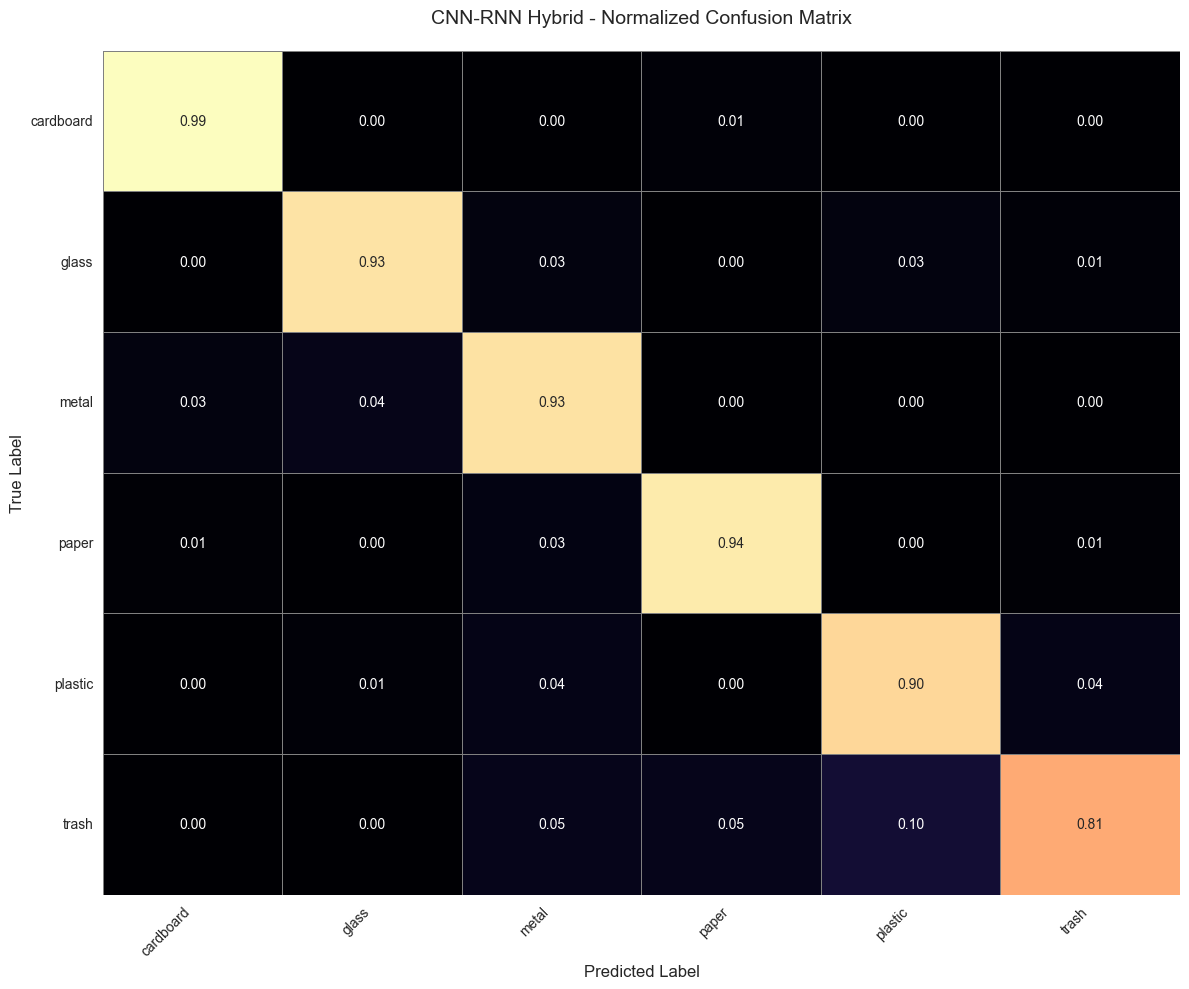


Evaluating CNN-RNN on Test Set
Successfully loaded CNN-RNN with strict=False



CNN-RNN Test Metrics:
- Accuracy: 0.9311
- Balanced Accuracy: 0.9165
- ROC AUC: 0.9839

Classification Report:
              precision    recall  f1-score   support

   cardboard     0.9577    0.9855    0.9714        69
       glass     0.9437    0.9306    0.9371        72
       metal     0.8750    0.9265    0.9000        68
       paper     0.9770    0.9444    0.9605        90
     plastic     0.9420    0.9028    0.9220        72
       trash     0.7727    0.8095    0.7907        21

    accuracy                         0.9311       392
   macro avg     0.9114    0.9165    0.9136       392
weighted avg     0.9324    0.9311    0.9314       392



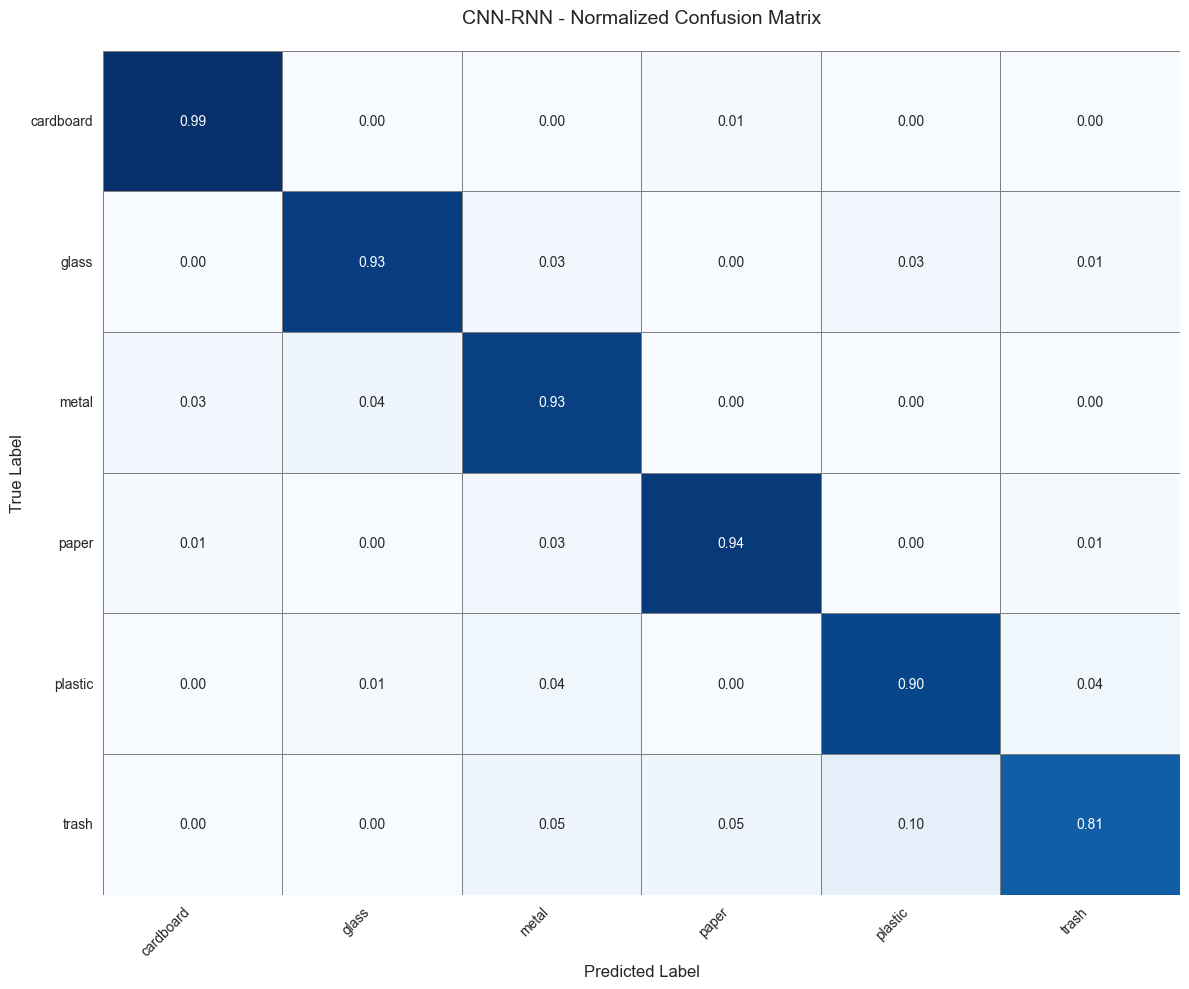



Model Comparison Summary
Model           Accuracy   Balanced Acc ROC AUC   
CNN-RNN         0.9311     0.9165       0.9839


In [20]:
# Load the best models
# 1. CNN-RNN
cnn_rnn_model = CNNRNNClassifier(num_classes).to(device)
cnn_rnn_model.load_state_dict(torch.load('saved_models/best_cnn_rnn_model.pth')['model_state_dict'])

# 2. CNN
#best_cnn_model = BestTunedCNN(num_classes, study_cnn.best_params).to(device)
#best_cnn_model.load_state_dict(torch.load('saved_models/best_cnn_model.pth'))

# 3. ANN (SimpleANN)
#best_ann_model = BestTunedANN(
#    flat_input_size,
#    [study_ann.best_params['num_hidden_1'], study_ann.best_params['num_hidden_2']],
#    num_classes,
#    study_ann.best_params['dropout']
#).to(device)
#best_ann_model.load_state_dict(torch.load('saved_models/best_ann_model.pth'))

# 4. GoogLeNet
#best_googlenet_model = initialize_best_googlenet(study_googlenet.best_params, num_classes).to(device)
#best_googlenet_model.load_state_dict(torch.load('saved_models/best_googlenet_model.pth'))

# Evaluate
cnn_rnn_results = evaluate_on_test_with_metrics(
    model=cnn_rnn_model,
    test_loader=test_loader,
    device=device,
    class_names=train_dataset.classes,
    model_name="CNN-RNN Hybrid"
)

# Print results
print("\n" + "="*60)
print("[CNN-RNN] Test Set Evaluation Results")
print("="*60)
print(f"- Accuracy: {cnn_rnn_results['accuracy']:.4f}")
print(f"- Balanced Accuracy: {cnn_rnn_results['balanced_accuracy']:.4f}")
print(f"- ROC AUC: {cnn_rnn_results['roc_auc']:.4f}")

print("\nClassification Report:")
print(cnn_rnn_results['classification_report'])

# Plot confusion matrix
plot_confusion_matrix(
    cm=cnn_rnn_results['confusion_matrix'],
    class_names=train_dataset.classes,
    model_name="CNN-RNN Hybrid",
    cmap='magma'  # Using magma colormap for better visual distinction
)

# If you want to compare with other models, create a models_dict first
models_dict = {
    'CNN-RNN': cnn_rnn_model.state_dict(),
    #'CNN': best_cnn_model.state_dict(),
    #'SimpleANN': best_ann_model.state_dict(),
    #'GoogLeNet': best_googlenet_model.state_dict()
}

test_results = evaluate_all_models(
    models_dict=models_dict,
    test_loader=test_loader,
    device=device,
    class_names=train_dataset.classes,
    img_size=128,
    num_classes=num_classes
)


---


# Milestone 4: Deployment and Monitoring

### Deployment

In [41]:
# Initialize the Dash app
app = dash.Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])
server = app.server

# Define the layout
app.layout = dbc.Container([
    html.H1("Garbage Classification System", className="text-center my-4"),
    html.Hr(),

    # Instruction Section
    dbc.Row([
        dbc.Col([
            html.Div([
                html.P("Upload an image of garbage to classify it into different categories. The system will predict the type of garbage with the highest confidence.")
            ], className="text-muted text-center mb-4"),
        ])
    ]),

    # Image upload section
    dbc.Row([
        dbc.Col([
            dcc.Upload(
                id='upload-image',
                children=html.Div([
                    'Drag and Drop or ',
                    html.A('Select an Image')
                ]),
                style={
                    'width': '100%',
                    'height': '120px',
                    'lineHeight': '120px',
                    'borderWidth': '2px',
                    'borderStyle': 'dashed',
                    'borderRadius': '10px',
                    'textAlign': 'center',
                    'margin': '20px',
                    'backgroundColor': '#f4f7fa'
                },
                multiple=False
            ),
        ], width=12),
    ]),

    # Image display and classification results
    dbc.Row([
        dbc.Col([
            html.Div(id='output-image-upload'),
        ], width=6),

        dbc.Col([
            html.Div(id='classification-results',
                     style={'marginTop': '20px'}),
            dcc.Loading(
                id="loading-results",
                type="circle",
                children=html.Div(id="loading-output")
            )
        ], width=6),
    ]),

    # Footer
    html.Hr(),
    html.Footer("Garbage Classification System © 2025",
                className="text-center text-muted py-3")
], fluid=True)

# Image preprocessing function
def preprocess_image(contents):
    try:
        # Decode the base64 image
        img_str = contents.split(",")[1]
        img_bytes = base64.b64decode(img_str)
        img = Image.open(io.BytesIO(img_bytes)).convert('RGB')

        # Define transformations
        transform = transforms.Compose([
            transforms.Resize((128, 128)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ])

        # Apply transformations and add batch dimension
        img_tensor = transform(img).unsqueeze(0)
        return img_tensor

    except Exception as e:
        print(f"Error processing image: {e}")
        return None

# Callback for image upload and classification
@app.callback(
    [Output('output-image-upload', 'children'),
     Output('classification-results', 'children')],
    [Input('upload-image', 'contents')],
    [State('upload-image', 'filename')]
)
def update_output(contents, filename):
    if contents is None:
        return [html.Div("No image uploaded yet."), ""]

    # Display the uploaded image
    img_html = html.Div([
        html.H5(filename),
        html.Img(src=contents, style={'height': '300px', 'width': 'auto'}),
        html.Hr()
    ])

    # Preprocess the image
    img_tensor = preprocess_image(contents)
    if img_tensor is None:
        return [img_html, html.Div("Error processing image.", className="text-danger")]

    # Move to device and predict
    img_tensor = img_tensor.to(device)
    with torch.no_grad():
        outputs = cnn_rnn_model(img_tensor)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        conf, preds = torch.max(probs, 1)

    # Get class name and confidence
    class_name = train_dataset.classes[preds.item()]
    confidence = conf.item() * 100

    # Create results display in a card format
    results = dbc.Card([
        dbc.CardHeader("Classification Results", className="bg-primary text-white"),
        dbc.CardBody([
            html.H4(f"Predicted Class: {class_name}", className="card-title"),
            html.P(f"Confidence: {confidence:.2f}%", className="card-text"),
            html.Hr(),
            html.H5("Class Probabilities:"),
            html.Ul([
                html.Li(f"{train_dataset.classes[i]}: {probs[0][i].item()*100:.2f}%")
                for i in range(len(train_dataset.classes))
            ])
        ])
    ])

    return [img_html, results]

if __name__ == '__main__':
    # Define number of output classes and device
    num_classes = len(train_dataset.classes)  # or set it manually if dataset isn't loaded here
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Instantiate and load the CNN-RNN model
    cnn_rnn_model = CNNRNNClassifier(num_classes=num_classes).to(device)
    cnn_rnn_model.load_state_dict(torch.load('saved_models/best_cnn_rnn_model.pth')['model_state_dict'])
    cnn_rnn_model.eval()

    # Run the Dash app in an external browser
    app.run(debug=True)

C:\Users\nagy1\AppData\Local\Temp\ipykernel_7384\211561330.py:149: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.



In [ ]:
# go to http://127.0.0.1:8050/

### Monitoring

In [35]:
# Initialize Dash app (if not already initialized)
app = Dash(__name__, external_stylesheets=[dbc.themes.BOOTSTRAP])

# Setup for Model Monitor
class ModelMonitor:
    def __init__(self, reference_data, model, class_names):
        """
        Initialize the monitoring system
        
        Args:
            reference_data: DataFrame containing training data statistics
            model: The trained model to monitor
            class_names: List of class names
        """
        self.reference_data = reference_data
        self.model = model
        self.class_names = class_names
        self.production_data = pd.DataFrame(columns=['timestamp', 'image_hash', 'prediction',
                                                     'confidence', 'true_label'])
        self.performance_metrics = pd.DataFrame(columns=['timestamp', 'accuracy', 'precision',
                                                         'recall', 'f1'])

        # Initialize drift detectors
        self.drift_detectors = {
            'ks_test': {'threshold': 0.05},
            'wasserstein': {'threshold': 0.1}
        }

        # Connect to MLflow
        mlflow.set_tracking_uri("http://localhost:5000")
        self.experiment_name = "garbage_classification_monitoring"
        try:
            mlflow.create_experiment(self.experiment_name)
        except:
            pass
        mlflow.set_experiment(self.experiment_name)

    def log_prediction(self, image, prediction, confidence, true_label=None):
        """Log a prediction for monitoring"""
        # Create image fingerprint (simplified)
        img_hash = hash(np.array(image).tobytes())

        # Record the prediction
        new_entry = {
            'timestamp': datetime.now(),
            'image_hash': img_hash,
            'prediction': prediction,
            'confidence': confidence,
            'true_label': true_label
        }

        self.production_data = self.production_data.append(new_entry, ignore_index=True)

        # Log to MLflow
        with mlflow.start_run():
            mlflow.log_metric("prediction_confidence", confidence)
            mlflow.log_param("predicted_class", self.class_names[prediction])
            if true_label is not None:
                mlflow.log_param("true_class", self.class_names[true_label])
                mlflow.log_metric("correct", int(prediction == true_label))

    def calculate_performance(self):
        """Calculate current performance metrics"""
        if len(self.production_data) < 10:  # Need minimum samples
            return None
        # Get records with ground truth
        valid_records = self.production_data.dropna(subset=['true_label'])
        if len(valid_records) == 0:
            return None

        y_true = valid_records['true_label']
        y_pred = valid_records['prediction']

        # Calculate metrics
        accuracy = accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred, normalize='true')

        # Update performance history
        new_metrics = {
            'timestamp': datetime.now(),
            'accuracy': accuracy,
            'precision': np.diag(cm) / np.sum(cm, axis=0),
            'recall': np.diag(cm) / np.sum(cm, axis=1),
            'f1': 2 * (precision * recall) / (precision + recall)
        }

        self.performance_metrics = self.performance_metrics.append(new_metrics, ignore_index=True)
        return new_metrics

    def detect_drift(self, current_batch):
        """Detect data drift between reference and current data"""
        drift_results = {}

        # 1. Feature-level drift (using image statistics)
        ref_stats = self.reference_data[['mean_pixel', 'std_pixel']]
        curr_stats = current_batch[['mean_pixel', 'std_pixel']]

        for stat in ['mean_pixel', 'std_pixel']:
            ks_stat, ks_p = ks_2samp(ref_stats[stat], curr_stats[stat])
            w_dist = wasserstein_distance(ref_stats[stat], curr_stats[stat])

            drift_results[stat] = {
                'ks_statistic': ks_stat,
                'ks_pvalue': ks_p,
                'wasserstein': w_dist,
                'drift_detected': ks_p < self.drift_detectors['ks_test']['threshold'] or
                                  w_dist > self.drift_detectors['wasserstein']['threshold']
            }

        # 2. Prediction drift (distribution of predicted classes)
        ref_pred_dist = self.reference_data['class_distribution']
        curr_pred_dist = current_batch['prediction'].value_counts(normalize=True)

        for class_name in self.class_names:
            ks_stat, ks_p = ks_2samp(
                ref_pred_dist[class_name],
                curr_pred_dist.get(class_name, 0)
            )

            drift_results[f'class_{class_name}'] = {
                'ks_statistic': ks_stat,
                'ks_pvalue': ks_p,
                'drift_detected': ks_p < self.drift_detectors['ks_test']['threshold']
            }

        # Log drift metrics
        with mlflow.start_run():
            for metric, values in drift_results.items():
                if 'drift_detected' in values:
                    mlflow.log_metric(f"{metric}_drift", int(values['drift_detected']))
                if 'ks_pvalue' in values:
                    mlflow.log_metric(f"{metric}_ks_pvalue", values['ks_pvalue'])
                if 'wasserstein' in values:
                    mlflow.log_metric(f"{metric}_wasserstein", values['wasserstein'])

        return drift_results

In [36]:
# Performance Monitoring Dashboard Component
def create_performance_monitoring():
    """Create a performance monitoring dashboard component"""
    return dbc.Card([
        dbc.CardHeader("Model Performance Monitoring", className="bg-primary text-white"),
        dbc.CardBody([
            dcc.Graph(id='accuracy-trend'),
            dcc.Graph(id='confusion-matrix'),
            dcc.Interval(id='update-interval', interval=60*1000, n_intervals=0)  # Update every minute
        ])
    ])

# Data Drift Detection Dashboard Component
def create_drift_detection():
    """Create a data drift detection dashboard component"""
    return dbc.Card([
        dbc.CardHeader("Data Drift Detection", className="bg-warning text-dark"),
        dbc.CardBody([
            dcc.Graph(id='feature-drift'),
            dcc.Graph(id='prediction-drift'),
            html.Div(id='drift-alerts')
        ])
    ])

In [37]:
# Layout for Dash app
app.layout = dbc.Container([
    # Add performance monitoring dashboard
    dbc.Row([dbc.Col(create_performance_monitoring(), width=12)], className="my-4"),
    # Add drift detection dashboard
    dbc.Row([dbc.Col(create_drift_detection(), width=12)], className="my-4"),
])

# Callback for performance monitoring
@app.callback(
    [Output('accuracy-trend', 'figure'),
     Output('confusion-matrix', 'figure')],
    [Input('update-interval', 'n_intervals')]
)
def update_performance(n):
    # Get recent performance data (last 7 days)
    recent_data = monitor.performance_metrics[
        monitor.performance_metrics['timestamp'] > (datetime.now() - pd.Timedelta(days=7))]

    # Create accuracy trend plot
    acc_fig = go.Figure()
    acc_fig.add_trace(go.Scatter(
        x=recent_data['timestamp'],
        y=recent_data['accuracy'],
        mode='lines+markers',
        name='Accuracy'
    ))
    acc_fig.update_layout(title='Accuracy Over Time', yaxis=dict(range=[0, 1]))

    # Create confusion matrix plot
    cm = confusion_matrix(
        monitor.production_data['true_label'].dropna(),
        monitor.production_data['prediction'].dropna(),
        normalize='true'
    )
    cm_fig = go.Figure(data=go.Heatmap(
        z=cm,
        x=monitor.class_names,
        y=monitor.class_names,
        colorscale='Blues'
    ))
    cm_fig.update_layout(title='Normalized Confusion Matrix')

    return acc_fig, cm_fig

# Callback for drift detection
@app.callback(
    [Output('feature-drift', 'figure'),
     Output('prediction-drift', 'figure'),
     Output('drift-alerts', 'children')],
    [Input('update-interval', 'n_intervals')]
)
def update_drift(n):
    # Get recent production data (last 24 hours)
    recent_data = monitor.production_data[
        monitor.production_data['timestamp'] > (datetime.now() - pd.Timedelta(hours=24))]

    if len(recent_data) == 0:
        return go.Figure(), go.Figure(), "No data available for drift detection"

    # Calculate drift
    drift_results = monitor.detect_drift(recent_data)

    # Create feature drift plot
    feature_fig = go.Figure()
    feature_fig.add_trace(go.Bar(
        x=['Mean Pixel', 'Std Pixel'],
        y=[drift_results['mean_pixel']['wasserstein'],
           drift_results['std_pixel']['wasserstein']],
        name='Wasserstein Distance'
    ))
    feature_fig.update_layout(title='Feature Distribution Drift')

    # Create prediction drift plot
    pred_fig = go.Figure()
    for class_name in monitor.class_names:
        pred_fig.add_trace(go.Bar(
            x=[class_name],
            y=[drift_results[f'class_{class_name}']['ks_pvalue']],
            name=class_name
        ))
    pred_fig.update_layout(title='Prediction Distribution Drift (KS p-values)')

    # Create alerts
    drift_alerts = []
    for feature, result in drift_results.items():
        if result.get('drift_detected', False):
            alert = dbc.Alert(
                f"Drift detected in {feature} (p={result['ks_pvalue']:.3f})",
                color="danger",
                dismissable=True,
                className="my-2"
            )
            drift_alerts.append(alert)

    return feature_fig, pred_fig, drift_alerts if drift_alerts else "No significant drift detected"

In [40]:
# Initialize monitoring system (ensure reference data is available)
reference_stats = pd.read_csv('reference_data_stats.csv')  # Pre-computed from training data
monitor = ModelMonitor(reference_stats, cnn_rnn_model, train_dataset.classes)

# Run the Dash app
if __name__ == "__main__":
    app.run_server(debug=True)